In [1]:
import pandas as pd
import numpy as np
import csv

# Convert prediction into quantile

In [2]:
def convert_prediction_to_quantile(df,option):
  pop = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/population.csv')
  pop['fips'] = pop['fips'].astype(str).str.zfill(2)
  df = df.merge(pop, on='fips', how='inner')
  if option == 0:
    df['Prediction_1w'] = (df['Prediction_1w'] * df['population'] / 100000).round().astype(int)
    df['Prediction_2w'] = (df['Prediction_2w'] * df['population'] / 100000).round().astype(int)
    df['Prediction_3w'] = (df['Prediction_3w'] * df['population'] / 100000).round().astype(int)
    df['Prediction_4w'] = (df['Prediction_4w'] * df['population'] / 100000).round().astype(int)
    df.drop(columns=['population'], inplace=True)
  result = df
  quantiles = np.array([0.01, 0.025] + list(np.arange(0.05, 0.95+0.05, 0.05)) + [0.975, 0.99])
  quantile_results = []  # Initialize an empty list to store the data frames

  grouped = df.groupby(['fips', 'Week_end'])

  for name, group in grouped:
      fips, week_end = name
      for i, prediction_column in enumerate(['Prediction_1w', 'Prediction_2w', 'Prediction_3w', 'Prediction_4w'], start=0):
          values = group[prediction_column].values
          quantile_values = np.percentile(values, quantiles * 100)
          # Create a DataFrame and append it to the list
          quantile_results.append(pd.DataFrame({
              'fips': [fips] * len(quantiles),
              'Week_end': [week_end] * len(quantiles),
              'horizon': [i] * len(quantiles),
              'Quantile': quantiles,
              'Value': quantile_values
          }))

  # Concatenate all the data frames in the list into a single data frame
  quantile_result = pd.concat(quantile_results, ignore_index=True)
  quantile_result.reset_index(drop=True, inplace=True)
  quantile_result['Week_end'] = quantile_result['Week_end'] + pd.DateOffset(days=7)
  quantile_result1 = quantile_result.copy()
  quantile_result1.rename(columns={
      'fips': 'location',
      'Week_end': 'reference_date',
      'horizon': 'horizon',
      'Quantile': 'output_type_id',
      'Value': 'value'
  }, inplace=True)


  quantile_result1['target'] = 'wk inc flu hosp'

  quantile_result1['horizon'] = quantile_result['horizon'].astype(int)  # Convert 'horizon' to integer if it's not already

  quantile_result1['target_end_date'] = quantile_result1['reference_date'] + quantile_result1['horizon'] * pd.to_timedelta(7, unit='D')
  quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
  quantile_result1['location'] = quantile_result1['location'].astype(str)
  quantile_result1['output_type'] = 'quantile'
  quantile_result1['value'] = np.where(quantile_result1['value'] < 0, 0, quantile_result1['value'])
  quantile_result1=quantile_result1[['reference_date', 'target', 'horizon', 'target_end_date', 'location', 'output_type', 'output_type_id', 'value']]
  return quantile_result1

In [3]:
def convert_prediction_to_quantile_adm(df):
  quantiles = np.array([0.01, 0.025] + list(np.arange(0.05, 0.95+0.05, 0.05)) + [0.975, 0.99])
  quantile_results = []  # Initialize an empty list to store the data frames

  grouped = df.groupby(['fips', 'Week_end'])

  for name, group in grouped:
      fips, week_end = name
      for i, prediction_column in enumerate(['Prediction_1w', 'Prediction_2w', 'Prediction_3w', 'Prediction_4w'], start=0):
          values = group[prediction_column].values
          quantile_values = np.percentile(values, quantiles * 100)
          # Create a DataFrame and append it to the list
          quantile_results.append(pd.DataFrame({
              'fips': [fips] * len(quantiles),
              'Week_end': [week_end] * len(quantiles),
              'horizon': [i] * len(quantiles),
              'Quantile': quantiles,
              'Value': quantile_values
          }))

  # Concatenate all the data frames in the list into a single data frame
  quantile_result = pd.concat(quantile_results, ignore_index=True)

  quantile_result['Week_end'] = pd.to_datetime(quantile_result['Week_end']) + pd.DateOffset(days=7)
  quantile_result1 = quantile_result.copy()
  quantile_result1.rename(columns={
      'fips': 'location',
      'Week_end': 'reference_date',
      'horizon': 'horizon',
      'Quantile': 'output_type_id',
      'Value': 'value'
  }, inplace=True)


  quantile_result1['target'] = 'wk inc flu hosp'

  quantile_result1['horizon'] = quantile_result['horizon'].astype(int)  # Convert 'horizon' to integer if it's not already

  quantile_result1['target_end_date'] = quantile_result1['reference_date'] + quantile_result1['horizon'] * pd.to_timedelta(7, unit='D')
  quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
  quantile_result1['location'] = quantile_result1['location'].astype(str)
  quantile_result1['output_type'] = 'quantile'
  quantile_result1['value'] = np.where(quantile_result1['value'] < 0, 0, quantile_result1['value'])
  quantile_result1=quantile_result1[['reference_date', 'target', 'horizon', 'target_end_date', 'location', 'output_type', 'output_type_id', 'value']]
  return quantile_result1

### Increase the interval

In [4]:

import math

def adjust_quantile_ranges_inplace(result_df):
    # Define the quantiles and adjustment factors
    quantiles = np.array([0.01, 0.025] + list(np.arange(0.05, 0.95 + 0.05, 0.05)) + [0.975, 0.99])
    adjustment_factors = {
        0: 2.0,
        1: 2.0,
        2: 2.0,
        3: 2.0
    }

    # Copy the DataFrame to avoid modifying the original
    df_copy = result_df.copy()
    df_copy['output_type_id'] = df_copy['output_type_id'].astype(float)

    # Calculate the adjustment factors for each horizon
    df_copy['adjustment_factor'] = df_copy['horizon'].map(adjustment_factors).fillna(1)

    # Get the median values for each location and horizon
    medians = df_copy[df_copy['output_type_id'] == 0.5].set_index(['location', 'horizon'])['value']


    df_copy = df_copy.join(medians, on=['location', 'horizon'], rsuffix='_median')
    df_copy['adjusted_value'] = df_copy['value']


    condition = df_copy['output_type_id'] != 0.5
    df_copy.loc[condition, 'adjusted_value'] = df_copy.loc[condition].apply(
        lambda row: row['value_median'] + (row['value'] - row['value_median']) * row['adjustment_factor'], axis=1
    )


    df_copy['value'] = df_copy['adjusted_value']


    df_copy.drop(columns=['adjustment_factor', 'value_median', 'adjusted_value'], inplace=True)

    df_copy['value'] = np.where(df_copy['value'] < 0, 0, df_copy['value'])
    return df_copy




# Calculate MAE

In [5]:
def mae_cal(quantile_result1,option):
  if option == 0:
    hist = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/smootheddata.csv')
    tgt = 'total_admissions'
  else:
    hist = pd.read_csv('/content/drive/MyDrive/RSV forecasting/Data/smoothedrate_withrsvww (1).csv')
    tgt = 'rsv_rate'
  hist['Week_end'] = pd.to_datetime(hist['Week_end'])
  hist['fips'] =hist['fips'].astype(str).str.zfill(2)
  quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
  quantile_result1['reference_date'] = pd.to_datetime(quantile_result1['reference_date'])
  quantile_result1['target_end_date'] = pd.to_datetime(quantile_result1['target_end_date'])
  desired_dates = quantile_result1['target_end_date'].unique()
  hist = hist[hist['Week_end'].isin(desired_dates)]
  hist = hist[['fips','Week_end',tgt]]
  regionresult = quantile_result1[quantile_result1['output_type_id']==0.500]
  merged_df = pd.merge(hist, regionresult, left_on=['fips', 'Week_end'], right_on=['location', 'target_end_date'])

  # Calculate the absolute difference between actual and predicted total admissions
  merged_df['absolute_difference'] = abs(merged_df[tgt] - merged_df['value'])

  # Calculate the Mean Absolute Error (MAE)
  mae = merged_df['absolute_difference'].mean()
  mae_by_horizon = merged_df.groupby('horizon')['absolute_difference'].mean()
  # Print the MAE
  merged_df1 = merged_df[['reference_date','location','horizon','absolute_difference']]
  print(f'Mean Absolute Error (MAE): {mae}')
  return merged_df1,mae,mae_by_horizon

In [6]:
def mae_cal1(quantile_result1,option,o):
  if option == 0:
    hist = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/smootheddata.csv')
    tgt = 'total_admissions'
  else:
    hist = pd.read_csv('/content/drive/MyDrive/RSV forecasting/Data/smoothedrate_withrsvww (1).csv')
    tgt = 'rsv_rate'
  hist['Week_end'] = pd.to_datetime(hist['Week_end'])
  hist['fips'] =hist['fips'].astype(str).str.zfill(2)
  quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
  quantile_result1['reference_date'] = pd.to_datetime(quantile_result1['reference_date'])
  quantile_result1['target_end_date'] = pd.to_datetime(quantile_result1['target_end_date'])
  desired_dates = quantile_result1['target_end_date'].unique()
  hist = hist[hist['Week_end'].isin(desired_dates)]
  hist = hist[['fips','Week_end',tgt]]
  regionresult = quantile_result1[quantile_result1['output_type_id']==0.500]
  merged_df = pd.merge(hist, regionresult, left_on=['fips', 'Week_end'], right_on=['location', 'target_end_date'])

  # Calculate the absolute difference between actual and predicted total admissions
  merged_df['absolute_difference'] = abs(merged_df[tgt] - merged_df['value'])

  # Calculate the Mean Absolute Error (MAE)
  mae = merged_df['absolute_difference'].mean()
  mae_by_horizon = merged_df.groupby('horizon')['absolute_difference'].mean()
  merged_df1 = merged_df[['reference_date','location','horizon','absolute_difference']]
  # Print the MAE
  if o ==1:
    print(f'Mean Absolute Error (MAE): {mae}')
  return merged_df1,mae,mae_by_horizon

In [7]:
def mae_cal2(quantile_result1,desired_dates,option,o):
  if option == 0:
    hist = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/smootheddata.csv')
    tgt = 'total_admissions'
  else:
    hist = pd.read_csv('/content/drive/MyDrive/RSV forecasting/Data/smoothedrate_withrsvww (1).csv')
    tgt = 'rsv_rate'
  hist['Week_end'] = pd.to_datetime(hist['Week_end'])
  hist['fips'] =hist['fips'].astype(str).str.zfill(2)
  quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
  quantile_result1['reference_date'] = pd.to_datetime(quantile_result1['reference_date'])
  quantile_result1['target_end_date'] = pd.to_datetime(quantile_result1['target_end_date'])
  #desired_dates = quantile_result1['target_end_date'].unique()
  hist = hist[hist['Week_end'].isin(desired_dates)]
  hist = hist[['fips','Week_end',tgt]]
  regionresult = quantile_result1[quantile_result1['output_type_id']==0.500]
  merged_df = pd.merge(hist, regionresult, left_on=['fips', 'Week_end'], right_on=['location', 'target_end_date'])

  # Calculate the absolute difference between actual and predicted total admissions
  merged_df['absolute_difference'] = abs(merged_df[tgt] - merged_df['value'])

  # Calculate the Mean Absolute Error (MAE)
  mae = merged_df['absolute_difference'].mean()
  mae_by_horizon = merged_df.groupby('horizon')['absolute_difference'].mean()
  # Print the MAE
  if o ==1:
    print(f'Mean Absolute Error (MAE): {mae}')
  return merged_df,mae,mae_by_horizon

In [8]:
import numpy as np
'''
def weighted_interval_score(quantiles, values, actual_value):
    """
    Compute the weighted interval score (WIS) for forecast evaluation.

    Parameters:
    - quantiles (list or np.array): Quantiles at which forecasts were made (e.g., [0.1, 0.5, 0.9]).
    - values (list or np.array): Forecasted values corresponding to the provided quantiles.
    - actual_value (float): The actual observed value.

    Returns:
    - float: The computed weighted interval score.
    """
    if np.isnan(actual_value):
        return np.nan
    not_nan_indices = ~np.isnan(quantiles)
    quantiles = np.array(quantiles)[not_nan_indices]
    values = np.array(values)[not_nan_indices]


    try:
        median_index = np.where(quantiles == 0.5)[0][0]
        median_forecast = values[median_index]
    except IndexError:
        return np.nan

    quantile_losses = []
    for q, v in zip(quantiles, values):
        loss = 2 * max(q * (actual_value - v), (1 - q) * (v - actual_value))
        quantile_losses.append(loss)

    wis = np.mean(quantile_losses)
    return wis
'''
import numpy as np

def quantile_loss(q, q_value, actual_value):
    """
    Compute the quantile loss (pinball loss) for a given quantile.

    Parameters:
    - q (float): The quantile (e.g., 0.1, 0.5, 0.9).
    - q_value (float): The forecasted value at quantile q.
    - actual_value (float): The actual observed value.

    Returns:
    - float: The quantile loss for quantile q.
    """
    if actual_value <= q_value:
        return 2 * (1 - q) * (q_value - actual_value)
    else:
        return 2 * q * (actual_value - q_value)

def weighted_interval_score(quantiles, values, actual_value):
    """
    Compute the weighted interval score (WIS) for forecast evaluation.

    Parameters:
    - quantiles (np.array): Quantiles at which forecasts were made.
    - values (np.array): Forecasted values corresponding to the provided quantiles.
    - actual_value (float): The actual observed value.

    Returns:
    - float: The computed weighted interval score.
    """
    if np.isnan(actual_value):
        return np.nan

    quantile_losses = []
    for q, v in zip(quantiles, values):
        loss = quantile_loss(q, v, actual_value)
        quantile_losses.append(loss)


    interval_scores = []


    for i in range(len(quantiles) - 1):
        lower_idx = i
        upper_idx = len(quantiles) - 1 - i
        interval_score = (quantile_losses[lower_idx] + quantile_losses[upper_idx]) / 2
        interval_scores.append(interval_score)

    wis = np.mean(interval_scores)
    return wis


def cal_wis(quantile_result, option):
    # Load historical data based on the option
    if option == 0:
        hist = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/smootheddata.csv')
        tgt = 'total_admissions'
    else:
        hist = pd.read_csv('/content/drive/MyDrive/RSV forecasting/Data/smoothedrate_withrsvww (1).csv')
        tgt = 'rsv_rate'

    hist['Week_end'] = pd.to_datetime(hist['Week_end'])
    hist['fips'] = hist['fips'].astype(str).str.zfill(2)

    quantile_result['location'] = quantile_result['location'].astype(str).str.zfill(2)
    quantile_result['reference_date'] = pd.to_datetime(quantile_result['reference_date'])
    quantile_result['target_end_date'] = pd.to_datetime(quantile_result['target_end_date'])

    desired_dates = quantile_result['target_end_date'].unique()
    hist = hist[hist['Week_end'].isin(desired_dates)]
    hist = hist[['fips', 'Week_end', tgt]]


    merged_df = pd.merge(hist, quantile_result, left_on=['fips', 'Week_end'], right_on=['location', 'target_end_date'])
    grouped = merged_df.groupby(['location', 'target_end_date', 'horizon'])


    wis_scores = []
    wis_by_horizon = {}
    wis_results = []
    for (location, date, horizon), group in grouped:
        actual_value = group[tgt].iloc[0]
        quantiles = group['output_type_id'].unique()
        #print(quantiles)
        values = group['value']
        wis = weighted_interval_score(quantiles, values, actual_value)
        wis_scores.append(wis)
        if horizon not in wis_by_horizon:
            wis_by_horizon[horizon] = []
        wis_by_horizon[horizon].append(wis)
        wis_results.append({
            "location": location,
            "date": date - pd.Timedelta(days=horizon * 7),
            "horizon": horizon,
            "WIS": wis
        })
    # Calculate mean WIS across all groups
    mean_wis = np.nanmean(wis_scores)
    wis_df = pd.DataFrame(wis_results)
    # Calculate mean WIS by horizon
    mean_wis_by_horizon = {h: np.nanmean(scores) for h, scores in wis_by_horizon.items()}

    print(f'Weighted Interval Score (WIS): {mean_wis}')
    #print(f'Mean WIS by Horizon: {mean_wis_by_horizon}')
    return wis_df, mean_wis, mean_wis_by_horizon

def cal_wis2(quantile_result,desired_dates, option):
    # Load historical data based on the option
    if option == 0:
        hist = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/smootheddata.csv')
        tgt = 'total_admissions'
    else:
        hist = pd.read_csv('/content/drive/MyDrive/RSV forecasting/Data/smoothedrate_withrsvww.csv')
        tgt = 'rsv_rate'

    hist['Week_end'] = pd.to_datetime(hist['Week_end'])
    hist['fips'] = hist['fips'].astype(str).str.zfill(2)
    hist = hist[hist['Week_end'].isin(desired_dates)]
    quantile_result['location'] = quantile_result['location'].astype(str).str.zfill(2)
    quantile_result['reference_date'] = pd.to_datetime(quantile_result['reference_date'])
    quantile_result['target_end_date'] = pd.to_datetime(quantile_result['target_end_date'])

    #desired_dates = quantile_result['target_end_date'].unique()
    hist = hist[hist['Week_end'].isin(desired_dates)]
    hist = hist[['fips', 'Week_end', tgt]]


    merged_df = pd.merge(hist, quantile_result, left_on=['fips', 'Week_end'], right_on=['location', 'target_end_date'])
    grouped = merged_df.groupby(['location', 'target_end_date', 'horizon'])


    wis_scores = []
    wis_by_horizon = {}
    wis_results = []
    for (location, date, horizon), group in grouped:
        actual_value = group[tgt].iloc[0]
        quantiles = group['output_type_id'].unique()
        #print(quantiles)
        values = group['value']
        wis = weighted_interval_score(quantiles, values, actual_value)
        wis_scores.append(wis)
        if horizon not in wis_by_horizon:
            wis_by_horizon[horizon] = []
        wis_by_horizon[horizon].append(wis)
        wis_results.append({
            "location": location,
            "date": date - pd.Timedelta(days=horizon * 7),
            "horizon": horizon,
            "WIS": wis
        })
    # Calculate mean WIS across all groups
    mean_wis = np.nanmean(wis_scores)
    wis_df = pd.DataFrame(wis_results)
    # Calculate mean WIS by horizon
    mean_wis_by_horizon = {h: np.nanmean(scores) for h, scores in wis_by_horizon.items()}

    #print(f'Weighted Interval Score (WIS): {mean_wis}')
    #print(f'Mean WIS by Horizon: {mean_wis_by_horizon}')
    return wis_df, mean_wis, mean_wis_by_horizon


# State Level exp

In [29]:
from datetime import datetime, timedelta
start_date = datetime.strptime('2023-10-07', '%Y-%m-%d')
end_date = datetime.strptime('2024-02-24', '%Y-%m-%d')
current_date = start_date
dates_list = []

while current_date <= end_date:
    dates_list.append(current_date.strftime('%Y-%m-%d'))
    current_date += timedelta(days=7)

test_weeks = dates_list
df1 = pd.DataFrame()
df2 = pd.DataFrame()
df3 = pd.DataFrame()
option = 1
mae_results = []
for test_week in test_weeks:
    print(test_week)

    file_path = f'/content/drive/MyDrive/RSV forecasting/Result/state level/{test_week}_quantileresultexp.csv'

    df = pd.read_csv(file_path)

    if option == 1:
      pop = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/population.csv')
      merged_df = pd.merge(df, pop, left_on='location', right_on='fips')
      merged_df['value'] = (merged_df['value'] * 100000) / merged_df['population']

      final_df = merged_df.drop(columns=['fips', 'population'])
      df = final_df
      df = adjust_quantile_ranges_inplace(df)
      #df.to_csv(f'/content/drive/MyDrive/Flu Forecasting/ARIMA/state result/{test_week}_quantileexp.csv',index=False)
      df.to_csv(f'/content/drive/MyDrive/RSV forecasting/Result/state level/{test_week}_quantileexplarger.csv',index=False)
      #break
    df1 = pd.concat([df1, df], ignore_index=True)
    mergeddf,mae,maewk = mae_cal(df,option)
    df2 = pd.concat([df2, mergeddf], ignore_index=True)
    me, mean_wis, mean_wis_by_horizon = cal_wis(df,option)
    df3 = pd.concat([df3, me], ignore_index=True)
    mae_results.append({
        'test_week': test_week,
        'horizon': 'Overall',
        'state MAE': mae,
        'state WIS':mean_wis
    })

    '''
    for horizon, horizon_mae in maewk.items():
        mae_results.append({
            'test_week': test_week,
            'horizon': f'{horizon}_w',
            'state MAE': horizon_mae
        })
    for horizon, horizon_wis in mean_wis_by_horizon.items():
        mae_results.append({
            'test_week': test_week,
            'horizon': f'{horizon}_w',
            'state WIS': horizon_wis
        })
    '''
    combined_horizon_results = {}


    for horizon, horizon_mae in maewk.items():
        combined_horizon_results[horizon] = {
            'state MAE': horizon_mae
        }


    for horizon, horizon_wis in mean_wis_by_horizon.items():
        if horizon in combined_horizon_results:
            combined_horizon_results[horizon]['state WIS'] = horizon_wis
        else:
            combined_horizon_results[horizon] = {'state WIS': horizon_wis}


    for horizon, metrics in combined_horizon_results.items():
        metrics.update({
            'test_week': test_week,
            'horizon': f'{horizon}_w'
        })
        mae_results.append(metrics)
mae_df = pd.DataFrame(mae_results)
df2.to_csv('/content/drive/MyDrive/RSV forecasting/Result/result/statemaelargerexp.csv', index=False)
df3.to_csv('/content/drive/MyDrive/RSV forecasting/Result/result/statewislargerexp.csv', index=False)

  #mae_df.to_csv('/content/drive/MyDrive/Flu Forecasting/result/statemae_rateexp.csv', index=False)
mae_df.to_csv('/content/drive/MyDrive/RSV forecasting/Result/result/statemae_rateexp.csv', index=False)



2023-10-07
Mean Absolute Error (MAE): 0.4464564174545429
Weighted Interval Score (WIS): 0.280063496998515
2023-10-14
Mean Absolute Error (MAE): 0.49934908302786124
Weighted Interval Score (WIS): 0.31975327956971766
2023-10-21
Mean Absolute Error (MAE): 0.47935177106777555
Weighted Interval Score (WIS): 0.32051173281464
2023-10-28
Mean Absolute Error (MAE): 0.7545341227457071
Weighted Interval Score (WIS): 0.4719905618269949
2023-11-04
Mean Absolute Error (MAE): 0.8148736695666616
Weighted Interval Score (WIS): 0.5632557546081914
2023-11-11
Mean Absolute Error (MAE): 1.2581293688411685
Weighted Interval Score (WIS): 0.8964696326196594
2023-11-18
Mean Absolute Error (MAE): 1.2960179748417386
Weighted Interval Score (WIS): 0.9234833431547583
2023-11-25
Mean Absolute Error (MAE): 1.6044917770079232
Weighted Interval Score (WIS): 1.1418990802539217
2023-12-02
Mean Absolute Error (MAE): 1.737178235829828
Weighted Interval Score (WIS): 1.2249134727772661
2023-12-09
Mean Absolute Error (MAE): 

In [ ]:
df2

,reference_date,location,horizon,absolute_difference
0,2023-10-07,06,0,0.295483
1,2023-10-07,06,1,1.698941
2,2023-10-07,06,2,0.438577
3,2023-10-07,06,3,1.571371
4,2023-10-07,08,0,1.063689
...,...,...,...,...
1003,2024-02-24,47,3,1.073441
1004,2024-02-24,49,0,1.231945
1005,2024-02-24,49,1,1.496167
1006,2024-02-24,49,2,0.376384


In [ ]:
a,mae,wk = mae_cal(df1,1)
print(wk)

Mean Absolute Error (MAE): 3.7550993344677592
horizon
0    2.076337
1    3.015321
2    4.222035
3    5.706705
Name: absolute_difference, dtype: float64


In [ ]:
a,wis,wk = cal_wis(df1,option)
print(wk)

Weighted Interval Score (WIS): 2.3499255326798827
{0: 1.6551087899581218, 1: 2.149370010620148, 2: 2.573980841359312, 3: 3.0212424887819482}


In [ ]:
a,mae,wk = mae_cal(df1,1)
print(wk)
a,wis,wk = cal_wis(df1,option)
print(wk)

Mean Absolute Error (MAE): 1.0990489700733796
horizon
0    0.711219
1    0.916999
2    1.214865
3    1.553113
Name: absolute_difference, dtype: float64
Weighted Interval Score (WIS): 0.7606315006054377
{0: 0.47283398450205966, 1: 0.6306274386161611, 2: 0.8508250704016516, 3: 1.088239508901879}


# US model

In [9]:
from datetime import datetime, timedelta
start_date = datetime.strptime('2023-10-07', '%Y-%m-%d')
end_date = datetime.strptime('2024-02-17', '%Y-%m-%d')
current_date = start_date
dates_list = []

while current_date <= end_date:
    dates_list.append(current_date.strftime('%Y-%m-%d'))
    current_date += timedelta(days=7)

test_weeks = dates_list
df1 = pd.DataFrame()
mae_results = []
option = 1
df2 = pd.DataFrame()
df3 = pd.DataFrame()
for test_week in test_weeks:
    print(test_week)
    test_week_datetime = datetime.strptime(test_week, '%Y-%m-%d')
    save_week = (test_week_datetime + timedelta(days=7)).strftime('%Y-%m-%d')
    file_path = f'/content/drive/MyDrive/RSV forecasting/Result/US level/raw output/1000 times/{test_week}_allresult.pkl'
    save_path = f'/content/drive/MyDrive/RSV forecasting/Result/US level/quantile result/{save_week}_quantile.csv'
    save_path1 = f'/content/drive/MyDrive/RSV forecasting/Result/US level/quantile result/{save_week}_quantilelarger.csv'
    # Load the summary table, sort it, and filter
    df = pd.read_pickle(file_path)

    qt = convert_prediction_to_quantile(df,option)
    qt = adjust_quantile_ranges_inplace(qt)
    qt.to_csv(save_path1,index = False)
    df1 = pd.concat([df1, qt], ignore_index=True)

    #qt.to_csv(save_path,index = False)

    mergeddf,mae,maewk = mae_cal(qt,option)
    df2 = pd.concat([df2, mergeddf], ignore_index=True)
    me, mean_wis, mean_wis_by_horizon = cal_wis(qt,option)
    df3 = pd.concat([df3, me], ignore_index=True)
    mae_results.append({
        'test_week': save_week,
        'horizon': 'Overall',
        'US MAE': mae,
        'US WIS': mean_wis
    })

    '''
    for horizon, horizon_mae in maewk.items():
        mae_results.append({
            'test_week': save_week,
            'horizon': f'{horizon}_w',
            'US MAE': horizon_mae
        })
    '''
    combined_horizon_results = {}


    for horizon, horizon_mae in maewk.items():
        combined_horizon_results[horizon] = {
            'US MAE': horizon_mae
        }


    for horizon, horizon_wis in mean_wis_by_horizon.items():
        if horizon in combined_horizon_results:
            combined_horizon_results[horizon]['US WIS'] = horizon_wis
        else:
            combined_horizon_results[horizon] = {'US WIS': horizon_wis}


    for horizon, metrics in combined_horizon_results.items():
        metrics.update({
            'test_week': save_week,
            'horizon': f'{horizon}_w'
        })
        mae_results.append(metrics)
mae_df = pd.DataFrame(mae_results)
df2.to_csv('/content/drive/MyDrive/RSV forecasting/Result/result/USmaelarger.csv', index=False)
df3.to_csv('/content/drive/MyDrive/RSV forecasting/Result/result/USwislarger.csv', index=False)


  #mae_df.to_csv('/content/drive/MyDrive/Flu Forecasting/result/USmae_rate.csv', index=False)
mae_df.to_csv('/content/drive/MyDrive/RSV forecasting/Result/result/USmae_rate.csv', index=False)

a,mae,wk = mae_cal(df1,option)
print(wk)
a,wis,wk = cal_wis(df1,option)
print(wk)

2023-10-07
Mean Absolute Error (MAE): 0.4164859674250086
Weighted Interval Score (WIS): 0.28532575079076783
2023-10-14
Mean Absolute Error (MAE): 0.4878935181846222
Weighted Interval Score (WIS): 0.3492921023211893
2023-10-21
Mean Absolute Error (MAE): 0.739247005751046
Weighted Interval Score (WIS): 0.5211008683585944
2023-10-28
Mean Absolute Error (MAE): 0.8392230106517672
Weighted Interval Score (WIS): 0.6027616427206152
2023-11-04
Mean Absolute Error (MAE): 1.210692844664057
Weighted Interval Score (WIS): 0.883427563947823
2023-11-11
Mean Absolute Error (MAE): 0.9227314148098231
Weighted Interval Score (WIS): 0.615264229644341
2023-11-18
Mean Absolute Error (MAE): 1.0854812604685626
Weighted Interval Score (WIS): 0.7046350783725015
2023-11-25
Mean Absolute Error (MAE): 1.194626193617781
Weighted Interval Score (WIS): 0.7775945171522286
2023-12-02
Mean Absolute Error (MAE): 1.2842644757280748
Weighted Interval Score (WIS): 0.886718465163395
2023-12-09
Mean Absolute Error (MAE): 1.33

In [ ]:
a,mae,wk = mae_cal(df1,option)
print(wk)

Mean Absolute Error (MAE): 3.071138105893818
horizon
0    2.515414
1    2.713049
2    3.239935
3    3.816155
Name: absolute_difference, dtype: float64


In [ ]:
a,wis,wk = cal_wis(df1,option)
print(wk)

Weighted Interval Score (WIS): 2.2153844895739954
{0: 1.7068261397712363, 1: 1.9097273610335388, 2: 2.36986080069575, 3: 2.8751236567954574}


# Weight Selection

## Directly taking the mean

In [10]:
from datetime import datetime, timedelta
start_date = datetime.strptime('2023-10-14', '%Y-%m-%d')
end_date = datetime.strptime('2024-02-24', '%Y-%m-%d')
current_date = start_date
dates_list = []

while current_date <= end_date:
    dates_list.append(current_date.strftime('%Y-%m-%d'))
    current_date += timedelta(days=7)

test_weeks = dates_list
def ensemble_by_mean(test_weeks):
  df0 = pd.DataFrame()
  dfmae = pd.DataFrame()
  dfwis = pd.DataFrame()
  mae_results = []
  for test_week in test_weeks:
    print(test_week)

    #save_path1 = f'/content/drive/MyDrive/Flu Forecasting/ensemble/mean/{test_week}_quantile.csv'
    save_path2 = f'/content/drive/MyDrive/RSV forecasting/ensemble/mean/{test_week}_quantilelargerexp.csv'



    file_path2 = f'/content/drive/MyDrive/RSV forecasting/Result/US level/quantile result/{test_week}_quantilelarger.csv'
    file_path3 = f'/content/drive/MyDrive/RSV forecasting/Result/state level/{test_week}_quantileexplarger.csv'
    df2 = pd.read_csv(file_path2)
    df3 = pd.read_csv(file_path3)

    combined_result = pd.concat([df2,df3],ignore_index=True)
    result_df = combined_result.groupby(['reference_date', 'target', 'horizon', 'target_end_date', 'location', 'output_type', 'output_type_id'])['value'].mean().reset_index()

    result_df.reset_index(drop=True, inplace=True)
    #result_df = adjust_quantile_ranges_inplace(result_df)
    result_df.to_csv(save_path2,index = False)
    #result_df.to_csv(save_path1,index = False)


    df0 = pd.concat([df0, result_df], ignore_index=True)
    mergeddf,mae,maewk = mae_cal(result_df,1)
    dfmae = pd.concat([dfmae, mergeddf], ignore_index=True)
    me, mean_wis, mean_wis_by_horizon = cal_wis(result_df,1)
    dfwis = pd.concat([dfwis, me], ignore_index=True)
    mae_results.append({
        'test_week': test_week,
        'horizon': 'Overall',
        f'Ensemble MAE(mean)': mae,
        f'Ensemble WIS(mean)':mean_wis
    })

    '''
    for horizon, horizon_mae in maewk.items():
        mae_results.append({
            'test_week': test_week,
            'horizon': f'{horizon}_w',
            f'Ensemble (mean,{option})': horizon_mae
        })
    '''
    combined_horizon_results = {}


    for horizon, horizon_mae in maewk.items():
        combined_horizon_results[horizon] = {
            f'Ensemble MAE(mean)': horizon_mae
        }


    for horizon, horizon_wis in mean_wis_by_horizon.items():
        if horizon in combined_horizon_results:
            combined_horizon_results[horizon][f'Ensemble WIS(mean)'] = horizon_wis
        else:
            combined_horizon_results[horizon] = {f'Ensemble WIS(mean)': horizon_wis}


    for horizon, metrics in combined_horizon_results.items():
        metrics.update({
            'test_week': test_week,
            'horizon': f'{horizon}_w'
        })
        mae_results.append(metrics)
    mae_df = pd.DataFrame(mae_results)
  dfmae.to_csv(f'/content/drive/MyDrive/RSV forecasting/Result/result/Ensemble_mean_maelargerexp.csv', index=False)
  dfwis.to_csv(f'/content/drive/MyDrive/RSV forecasting/Result/result/Ensemble_mean_wislargerexp.csv', index=False)
  #mae_df.to_csv(f'/content/drive/MyDrive/Flu Forecasting/result/Ensemble_mean_{option}_mae_rate.csv', index=False)
  mae_df.to_csv(f'/content/drive/MyDrive/RSV forecasting/Result/result/Ensemble_mean_mae_rateexp.csv', index=False)
  return df0,result_df

In [11]:
df1,result = ensemble_by_mean(test_weeks)
a,mae,wk = mae_cal(df1,1)
print(wk)
me, mean_wis, mean_wis_by_horizon = cal_wis(df1,1)
print(mean_wis_by_horizon)

2023-10-14
Mean Absolute Error (MAE): 0.42228111652142
Weighted Interval Score (WIS): 0.27050868624579677
2023-10-21
Mean Absolute Error (MAE): 0.44811217669336373
Weighted Interval Score (WIS): 0.29782790034033435
2023-10-28
Mean Absolute Error (MAE): 0.664993287270685
Weighted Interval Score (WIS): 0.42861889190518676
2023-11-04
Mean Absolute Error (MAE): 0.7812158553090106
Weighted Interval Score (WIS): 0.5401453118641842
2023-11-11
Mean Absolute Error (MAE): 1.1869321216705593
Weighted Interval Score (WIS): 0.8509541302263065
2023-11-18
Mean Absolute Error (MAE): 1.0174632241626245
Weighted Interval Score (WIS): 0.7103857556510498
2023-11-25
Mean Absolute Error (MAE): 1.3034114829230654
Weighted Interval Score (WIS): 0.8599458608911656
2023-12-02
Mean Absolute Error (MAE): 1.3759952982646542
Weighted Interval Score (WIS): 0.9053497588402264
2023-12-09
Mean Absolute Error (MAE): 1.556490086007427
Weighted Interval Score (WIS): 1.088197993071256
2023-12-16
Mean Absolute Error (MAE): 

## weight selected by  reciprocal of 4 weeks mae

In [12]:
from datetime import datetime, timedelta
start_date = datetime.strptime('2023-10-14', '%Y-%m-%d')
end_date = datetime.strptime('2024-02-24', '%Y-%m-%d')
current_date = start_date
dates_list = []

while current_date <= end_date:
    dates_list.append(current_date.strftime('%Y-%m-%d'))
    current_date += timedelta(days=7)

test_weeks = dates_list


def ensemble_by_reci(test_weeks):
    df0 = pd.DataFrame()
    dfmae = pd.DataFrame()
    dfwis = pd.DataFrame()
    mae_results = []
    weight_records = []
    for i, test_week in enumerate(test_weeks):
        #if i == 0:
         #   continue
        print(test_week)
        # Path setup based on selected option


        save_path = '/content/drive/MyDrive/RSV forecasting/ensemble/reciprocal mae/'

        # Load current week's data

        df2 = pd.read_csv(f'/content/drive/MyDrive/RSV forecasting/Result/US level/quantile result/{test_week}_quantilelarger.csv')
        df3 = pd.read_csv(f'/content/drive/MyDrive/RSV forecasting/Result/state level/{test_week}_quantileexplarger.csv')
        if i == 0:
            combined_result = pd.concat([df2,df3],ignore_index=True)
            result_df = combined_result.groupby(['reference_date', 'target', 'horizon', 'target_end_date', 'location', 'output_type', 'output_type_id'])['value'].mean().reset_index()
            result_df.reset_index(drop=True, inplace=True)
            weight_records.append({'test_week': test_week, 'US_level': 0.5, 'state_level':0.5})
        else:
            # Calculate MAEs from past weeks
            past_weeks = test_weeks[max(0, i-4):i]
            mae1, mae2, mae3 = [], [], []
            for pw in past_weeks:

                past_df2 = pd.read_csv(f'/content/drive/MyDrive/RSV forecasting/Result/US level/quantile result/{pw}_quantilelarger.csv')
                past_df3 = pd.read_csv(f'/content/drive/MyDrive/RSV forecasting/Result/state level/{pw}_quantileexplarger.csv')
                week_list = test_weeks[test_weeks.index(pw):i]

                mae2.append(mae_cal2(past_df2,week_list, 1,0)[1])
                mae3.append(mae_cal2(past_df3,week_list, 1,0)[1])

            # Average MAE across the period
            mae2_mean, mae3_mean = np.mean(mae2), np.mean(mae3)

            # Merge dataframes and apply conditional weights
            full_df = df2.merge(df3, on=['reference_date', 'target', 'horizon', 'target_end_date', 'location', 'output_type', 'output_type_id'], how='outer', suffixes=('_2', '_3'))


            weights_23 = np.reciprocal([mae2_mean, mae3_mean])


            weights_23 /= np.sum(weights_23)
            weight_records.append({'test_week': test_week,  'US_level': weights_23[0], 'state_level': weights_23[1]})

            full_df['value'] = full_df.apply(
                lambda x: (x['value_2'] * weights_23[0] + x['value_3'] * weights_23[1]),
                axis=1
            )

            # Save the result
            result_df = full_df[['reference_date', 'target', 'horizon', 'target_end_date', 'location', 'output_type', 'output_type_id', 'value']]

        #result_df = adjust_quantile_ranges_inplace(result_df)
        result_df.to_csv(f'{save_path}{test_week}_quantilelargerexp.csv', index=False)


        df0 = pd.concat([df0, result_df], ignore_index=True)
        mergeddf,mae,maewk = mae_cal1(result_df,1,1)
        dfmae = pd.concat([dfmae, mergeddf], ignore_index=True)
        me, mean_wis, mean_wis_by_horizon = cal_wis(result_df,1)
        dfwis = pd.concat([dfwis, me], ignore_index=True)
        mae_results.append({
            'test_week': test_week,
            'horizon': 'Overall',
            f'Ensemble MAE(reci)': mae,
            f'Ensemble WIS(reci)': mean_wis
        })

        '''
        for horizon, horizon_mae in maewk.items():
            mae_results.append({
                'test_week': test_week,
                'horizon': f'{horizon}_w',
                f'Ensemble (reci,{option})': horizon_mae
            })
        '''
        combined_horizon_results = {}


        for horizon, horizon_mae in maewk.items():
            combined_horizon_results[horizon] = {
                f'Ensemble MAE(reci)': horizon_mae
            }


        for horizon, horizon_wis in mean_wis_by_horizon.items():
            if horizon in combined_horizon_results:
                combined_horizon_results[horizon][f'Ensemble WIS(reci)'] = horizon_wis
            else:
                combined_horizon_results[horizon] = {f'Ensemble WIS(reci)': horizon_wis}


        for horizon, metrics in combined_horizon_results.items():
            metrics.update({
                'test_week': test_week,
                'horizon': f'{horizon}_w'
            })
            mae_results.append(metrics)
        mae_df = pd.DataFrame(mae_results)
        weight_df = pd.DataFrame(weight_records)
    dfmae.to_csv(f'/content/drive/MyDrive/RSV forecasting/Result/result/Ensemble_reci_maelargerexp.csv', index=False)
    dfwis.to_csv(f'/content/drive/MyDrive/RSV forecasting/Result/result/Ensemble_reci_wislargerexp.csv', index=False)

    mae_df.to_csv(f'/content/drive/MyDrive/RSV forecasting/Result/result/Ensemble_reci_mae_rateexp.csv', index=False)
    weight_df.to_csv(f'/content/drive/MyDrive/RSV forecasting/Result/weight/Ensemble_reci_weightexp.csv', index=False)
    return df0,result_df,mae_df

In [13]:
df1,result,mae_df = ensemble_by_reci(test_weeks)
a,mae,wk = mae_cal(df1,1)
print(wk)
me, mean_wis, mean_wis_by_horizon = cal_wis(df1,1)
print(mean_wis_by_horizon)

2023-10-14
Mean Absolute Error (MAE): 0.42228111652142
Weighted Interval Score (WIS): 0.27050868624579677
2023-10-21


<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-6-e62f0be76d3e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

Mean Absolute Error (MAE): 0.4481325691435139
Weighted Interval Score (WIS): 0.29787846315479277
2023-10-28


<ipython-input-6-e62f0be76d3e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
<ipython-input-6-e62f0be76d3e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['reference_date'] = pd.to_datetime(quantile_result1['reference_date'])
<ipython-input-6-e62f0be76d3e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

Mean Absolute Error (MAE): 0.6641682122772107
Weighted Interval Score (WIS): 0.4283369420109177
2023-11-04


<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin

Mean Absolute Error (MAE): 0.7819477908199556
Weighted Interval Score (WIS): 0.5412590772318809
2023-11-11


<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin

Mean Absolute Error (MAE): 1.1852524315318818
Weighted Interval Score (WIS): 0.8496948664162437
2023-11-18


<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin

Mean Absolute Error (MAE): 1.0224617966437355
Weighted Interval Score (WIS): 0.7145735548260825
2023-11-25


<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin

Mean Absolute Error (MAE): 1.2991357742068796
Weighted Interval Score (WIS): 0.8557973371080171
2023-12-02


<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin

Mean Absolute Error (MAE): 1.356382967156146
Weighted Interval Score (WIS): 0.8883831419679472
2023-12-09


<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin

Mean Absolute Error (MAE): 1.472067570424359
Weighted Interval Score (WIS): 1.0296503148619702
2023-12-16


<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin

Mean Absolute Error (MAE): 1.5471829838499536
Weighted Interval Score (WIS): 1.1300036453625386
2023-12-23


<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin

Mean Absolute Error (MAE): 1.2290163926201798
Weighted Interval Score (WIS): 0.8200685421335079
2023-12-30


<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin

Mean Absolute Error (MAE): 0.9911833531086792
Weighted Interval Score (WIS): 0.6590022337846636
2024-01-06


<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin

Mean Absolute Error (MAE): 0.6761780626423087
Weighted Interval Score (WIS): 0.5155322048328512
2024-01-13


<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin

Mean Absolute Error (MAE): 0.7966604403004559
Weighted Interval Score (WIS): 0.5456247371120009
2024-01-20


<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin

Mean Absolute Error (MAE): 0.5158881176493031
Weighted Interval Score (WIS): 0.3641464535285153
2024-01-27


<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin

Mean Absolute Error (MAE): 0.4604317681452718
Weighted Interval Score (WIS): 0.2995792525543733
2024-02-03


<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin

Mean Absolute Error (MAE): 0.4604535708139501
Weighted Interval Score (WIS): 0.30552097820011
2024-02-10


<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin

Mean Absolute Error (MAE): 0.35424674375185966
Weighted Interval Score (WIS): 0.23997900515007772
2024-02-17


<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin

Mean Absolute Error (MAE): 0.36993970637041446
Weighted Interval Score (WIS): 0.25209140886023573
2024-02-24


<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin

Mean Absolute Error (MAE): 0.38458186680361733
Weighted Interval Score (WIS): 0.24683451715544624
Mean Absolute Error (MAE): 0.8218796617390549
horizon
0    0.582506
1    0.721574
2    0.896129
3    1.087310
Name: absolute_difference, dtype: float64
Weighted Interval Score (WIS): 0.5627232681248985
{0: 0.38410425138618604, 1: 0.4931425144782031, 2: 0.6127927671149682, 3: 0.7608535395202367}


## weight selected by  reciprocal of each week's mae

In [14]:
from datetime import datetime, timedelta
start_date = datetime.strptime('2023-10-14', '%Y-%m-%d')
end_date = datetime.strptime('2024-02-24', '%Y-%m-%d')
current_date = start_date
dates_list = []

while current_date <= end_date:
    dates_list.append(current_date.strftime('%Y-%m-%d'))
    current_date += timedelta(days=7)

test_weeks = dates_list


def ensemble_by_recihorizon(test_weeks):
    df0 = pd.DataFrame()
    dfmae = pd.DataFrame()
    dfwis = pd.DataFrame()
    mae_results = []
    weight_records = []
    for i, test_week in enumerate(test_weeks):
        #if i == 0:
         #   continue
        print(test_week)
        weights = {}

        # Path setup based on selected option


        save_path = '/content/drive/MyDrive/RSV forecasting/ensemble/reci mae by horizon/'

        # Load current week's data

        df2 = pd.read_csv(f'/content/drive/MyDrive/RSV forecasting/Result/US level/quantile result/{test_week}_quantilelarger.csv')
        df3 = pd.read_csv(f'/content/drive/MyDrive/RSV forecasting/Result/state level/{test_week}_quantileexplarger.csv')
        if i <= 3:
            combined_result = pd.concat([df2,df3],ignore_index=True)
            result_df = combined_result.groupby(['reference_date', 'target', 'horizon', 'target_end_date', 'location', 'output_type', 'output_type_id'])['value'].mean().reset_index()
            result_df.reset_index(drop=True, inplace=True)
            weight_records.append({'test_week': test_week,'horizon': 'overall', 'US_level': 0.5, 'state_level':0.5})
        else:
            # Calculate MAEs from past weeks
            #past_weeks = test_weeks[max(0, i-4):i ]
            mae2, mae3 = [], []
            horizons = [0,1,2,3]
            for horizon in horizons:
                past_weeks = test_weeks[max(0, i-4):i - horizon] if (i - horizon) > 0 else []
                mae2, mae3 = [], []
                for pw in past_weeks:

                    past_df2 = pd.read_csv(f'/content/drive/MyDrive/RSV forecasting/Result/US level/quantile result/{pw}_quantilelarger.csv').query('horizon == @horizon')
                    past_df3 = pd.read_csv(f'/content/drive/MyDrive/RSV forecasting/Result/state level/{pw}_quantileexplarger.csv').query('horizon == @horizon')
                    week_list = test_weeks[test_weeks.index(pw):i]

                    if not past_df2.empty:
                        mae2.append(mae_cal2(past_df2, week_list, 1, 0)[1])
                    if not past_df3.empty:
                        mae3.append(mae_cal2(past_df3, week_list, 1, 0)[1])

                # Calculate average MAE per horizon, ensuring we avoid division by zero

                mae2_mean = np.mean(mae2) if mae2 else np.inf
                mae3_mean = np.mean(mae3) if mae3 else np.inf

                reciprocal_weights = np.reciprocal([ mae2_mean, mae3_mean])
                normalized_weights = reciprocal_weights / reciprocal_weights.sum()
                weights[horizon] = normalized_weights

                # Store the weights for each horizon
                weight_records.append({
                    'test_week': test_week,
                    'horizon': horizon,
                    'US_level': normalized_weights[0],
                    'state_level': normalized_weights[1]
                })


            mae2_mean, mae3_mean =  np.mean(mae2), np.mean(mae3)

            # Merge dataframes and apply conditional weights
        full_df = pd.merge(df2, df3, on=['reference_date', 'target', 'horizon', 'target_end_date', 'location', 'output_type', 'output_type_id'], how='outer', suffixes=('_2', '_3'))


        full_df['value'] = full_df.apply(
            lambda x: (
                x['value_2'] * weights.get(x['horizon'], [0.5, 0.5])[0] +
                x['value_3'] * weights.get(x['horizon'], [0.5, 0.5])[1]
            ),
            axis=1
        )

            # Save the result
        result_df = full_df[['reference_date', 'target', 'horizon', 'target_end_date', 'location', 'output_type', 'output_type_id', 'value']]
        #result_df = adjust_quantile_ranges_inplace(result_df)
        result_df.to_csv(f'{save_path}{test_week}_quantilelargerexp.csv', index=False)



        df0 = pd.concat([df0, result_df], ignore_index=True)
        mergeddf,mae,maewk = mae_cal1(result_df,1,1)
        dfmae = pd.concat([dfmae, mergeddf], ignore_index=True)
        me, mean_wis, mean_wis_by_horizon = cal_wis(result_df,1)
        dfwis = pd.concat([dfwis, me], ignore_index=True)
        mae_results.append({
            'test_week': test_week,
            'horizon': 'Overall',
            f'Ensemble MAE(reci by horizon)': mae,
            f'Ensemble WIS(reci by horizon)': mean_wis
        })

        '''
        for horizon, horizon_mae in maewk.items():
            mae_results.append({
                'test_week': test_week,
                'horizon': f'{horizon}_w',
                f'Ensemble (reci by horizon,{option})': horizon_mae
            })
        '''
        combined_horizon_results = {}


        for horizon, horizon_mae in maewk.items():
            combined_horizon_results[horizon] = {
                f'Ensemble MAE(reci by horizon)': horizon_mae
            }


        for horizon, horizon_wis in mean_wis_by_horizon.items():
            if horizon in combined_horizon_results:
                combined_horizon_results[horizon][f'Ensemble WIS(reci by horizon)'] = horizon_wis
            else:
                combined_horizon_results[horizon] = {f'Ensemble WIS(reci by horizon)': horizon_wis}


        for horizon, metrics in combined_horizon_results.items():
            metrics.update({
                'test_week': test_week,
                'horizon': f'{horizon}_w'
            })
            mae_results.append(metrics)
        mae_df = pd.DataFrame(mae_results)
        weight_df = pd.DataFrame(weight_records)
    dfmae.to_csv(f'/content/drive/MyDrive/RSV forecasting/Result/result/Ensemble_reci by horizon_maelargerexp.csv', index=False)
    dfwis.to_csv(f'/content/drive/MyDrive/RSV forecasting/Result/result/Ensemble_reci by horizon_wislargerexp.csv', index=False)

    mae_df.to_csv(f'/content/drive/MyDrive/RSV forecasting/Result/result/Ensemble_reci by horizon_mae_rateexp.csv', index=False)
    weight_df.to_csv(f'/content/drive/MyDrive/RSV forecasting/Result/weight/Ensemble_reci by horizon_weightexp.csv', index=False)
    return df0,result_df,mae_df

In [15]:
df1,result,mae_df = ensemble_by_recihorizon(test_weeks)
a,mae,wk = mae_cal(df1,1)
print(wk)
me, mean_wis, mean_wis_by_horizon = cal_wis(df1,1)
print(mean_wis_by_horizon)

2023-10-14


<ipython-input-6-e62f0be76d3e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
<ipython-input-6-e62f0be76d3e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['reference_date'] = pd.to_datetime(quantile_result1['reference_date'])
<ipython-input-6-e62f0be76d3e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

Mean Absolute Error (MAE): 0.42228111652142
Weighted Interval Score (WIS): 0.27050868624579677
2023-10-21


<ipython-input-6-e62f0be76d3e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
<ipython-input-6-e62f0be76d3e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['reference_date'] = pd.to_datetime(quantile_result1['reference_date'])
<ipython-input-6-e62f0be76d3e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

Mean Absolute Error (MAE): 0.44811217669336373
Weighted Interval Score (WIS): 0.29782790034033435
2023-10-28


<ipython-input-6-e62f0be76d3e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
<ipython-input-6-e62f0be76d3e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['reference_date'] = pd.to_datetime(quantile_result1['reference_date'])
<ipython-input-6-e62f0be76d3e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

Mean Absolute Error (MAE): 0.664993287270685
Weighted Interval Score (WIS): 0.42861889190518676
2023-11-04


<ipython-input-6-e62f0be76d3e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
<ipython-input-6-e62f0be76d3e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['reference_date'] = pd.to_datetime(quantile_result1['reference_date'])
<ipython-input-6-e62f0be76d3e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

Mean Absolute Error (MAE): 0.7812158553090106
Weighted Interval Score (WIS): 0.5401453118641842
2023-11-11


<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin

Mean Absolute Error (MAE): 1.1829188666168193
Weighted Interval Score (WIS): 0.8481141865035284
2023-11-18


<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin

Mean Absolute Error (MAE): 1.0243723134977383
Weighted Interval Score (WIS): 0.7181117948407462
2023-11-25


<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin

Mean Absolute Error (MAE): 1.3026784248396723
Weighted Interval Score (WIS): 0.8595982622768493
2023-12-02


<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin

Mean Absolute Error (MAE): 1.3733620240902262
Weighted Interval Score (WIS): 0.9019524748470747
2023-12-09


<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin

Mean Absolute Error (MAE): 1.4898847051963575
Weighted Interval Score (WIS): 1.04383772806958
2023-12-16


<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin

Mean Absolute Error (MAE): 1.5438650014039126
Weighted Interval Score (WIS): 1.1274790991890657
2023-12-23


<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin

Mean Absolute Error (MAE): 1.2312171983728775
Weighted Interval Score (WIS): 0.8196256873015941
2023-12-30


<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin

Mean Absolute Error (MAE): 0.9862337572807834
Weighted Interval Score (WIS): 0.6552684430048679
2024-01-06


<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin

Mean Absolute Error (MAE): 0.6565127023056391
Weighted Interval Score (WIS): 0.49809018165915814
2024-01-13


<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin

Mean Absolute Error (MAE): 0.7683217663527859
Weighted Interval Score (WIS): 0.5285126086287822
2024-01-20


<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin

Mean Absolute Error (MAE): 0.5115357814607999
Weighted Interval Score (WIS): 0.3634957305944226
2024-01-27


<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin

Mean Absolute Error (MAE): 0.45762076500154153
Weighted Interval Score (WIS): 0.29983357545913786
2024-02-03


<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin

Mean Absolute Error (MAE): 0.4650246150325046
Weighted Interval Score (WIS): 0.3071303906407142
2024-02-10


<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin

Mean Absolute Error (MAE): 0.3408846935410583
Weighted Interval Score (WIS): 0.22754179386203485
2024-02-17


<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin

Mean Absolute Error (MAE): 0.35425720162160806
Weighted Interval Score (WIS): 0.243350529161542
2024-02-24


<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin(desired_dates)]
<ipython-input-7-678f0e01d44f>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  hist = hist[hist['Week_end'].isin

Mean Absolute Error (MAE): 0.3708260719741463
Weighted Interval Score (WIS): 0.23979507665155664
Mean Absolute Error (MAE): 0.8188059162191476
horizon
0    0.580161
1    0.719975
2    0.894775
3    1.080313
Name: absolute_difference, dtype: float64
Weighted Interval Score (WIS): 0.5609419176523078
{0: 0.38340022091134585, 1: 0.49291295359273446, 2: 0.6107779883069441, 3: 0.7566765077982072}


## Linear programming

In [16]:
!pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 66.4 MB/s eta 0:00:00


In [17]:
import gurobipy as gp
from gurobipy import GRB
def LP(X,y_true):
    m = gp.Model("ensemble_mae_minimization3")

    n_predictors = X.shape[1]
    n_samples = X.shape[0]


    weights = m.addVars(n_predictors, lb=0, ub=1, name="weights")
    aux_vars = m.addVars(n_samples, lb=0, name="aux")


    m.setObjective(aux_vars.sum() / n_samples, GRB.MINIMIZE)


    m.addConstr(weights.sum() == 1, "sum_of_weights")


    for i in range(n_samples):
        m.addConstr(aux_vars[i] >= gp.quicksum(weights[j] * X[i, j] for j in range(n_predictors)) - y_true[i])
        m.addConstr(aux_vars[i] >= y_true[i] - gp.quicksum(weights[j] * X[i, j] for j in range(n_predictors)))

    m.setParam('OutputFlag', 0)
    m.optimize()

    optimized_weights = [weights[j].X for j in range(n_predictors)]
    return optimized_weights

In [18]:
import gurobipy as gp
from gurobipy import GRB

from datetime import datetime, timedelta
start_date = datetime.strptime('2023-10-14', '%Y-%m-%d')
end_date = datetime.strptime('2024-02-24', '%Y-%m-%d')
current_date = start_date
dates_list = []

while current_date <= end_date:
    dates_list.append(current_date.strftime('%Y-%m-%d'))
    current_date += timedelta(days=7)

test_weeks = dates_list


def ensemble_by_LP(test_weeks,week):
    '''
    test_weeks: the list of week that we want to ensemble
    week: the week that we want to minize the mae (1,2,3,4), if 4, means we want to use
    '''
    df0 = pd.DataFrame()
    dfmae = pd.DataFrame()
    dfwis = pd.DataFrame()
    mae_results = []
    weight_records = []
    for i, test_week in enumerate(test_weeks):

        print(test_week)
        # Path setup based on selected option


        save_path = '/content/drive/MyDrive/RSV forecasting/ensemble/reci mae by horizon/'

        # Load current week's data

        df2 = pd.read_csv(f'/content/drive/MyDrive/RSV forecasting/Result/US level/quantile result/{test_week}_quantilelarger.csv')
        df3 = pd.read_csv(f'/content/drive/MyDrive/RSV forecasting/Result/state level/{test_week}_quantileexplarger.csv')
        if i <= week - 1:
            combined_result = pd.concat([df2,df3],ignore_index=True)
            result_df = combined_result.groupby(['reference_date', 'target', 'horizon', 'target_end_date', 'location', 'output_type', 'output_type_id'])['value'].mean().reset_index()
            result_df.reset_index(drop=True, inplace=True)
            weight_records.append({'test_week': test_week, 'US_level': 0.5, 'state_level':0.5})
        else:
            pw = test_weeks[i-week]

            past_df2 = pd.read_csv(f'/content/drive/MyDrive/RSV forecasting/Result/US level/quantile result/{pw}_quantilelarger.csv')
            past_df3 = pd.read_csv(f'/content/drive/MyDrive/RSV forecasting/Result/state level/{pw}_quantileexplarger.csv')
            desired_week = test_weeks[i-week:i]

            past_df2 = past_df2[(past_df2['target_end_date'].isin(desired_week)) & (past_df2['output_type_id'] == 0.5)]
            past_df3 = past_df3[(past_df3['target_end_date'].isin(desired_week)) & (past_df3['output_type_id'] == 0.5)]

            full_df1 = past_df2.merge(past_df3, on=['reference_date', 'target', 'horizon', 'target_end_date', 'location', 'output_type', 'output_type_id'], how='outer', suffixes=('_2', '_3'))
            #print(full_df1)

            full_df1['location'] = full_df1['location'].astype(str).str.zfill(2)
            gd = pd.read_csv('/content/drive/MyDrive/RSV forecasting/Data/smoothedrate_withrsvww (1).csv')
            gd = gd[['Week_end', 'fips','rsv_rate']]

            gd = gd[['Week_end', 'fips','rsv_rate']].reset_index(drop=True)
            gd['fips'] =gd['fips'].astype(str).str.zfill(2)
            gd.rename(columns={'Week_end': 'target_end_date', 'fips': 'location'}, inplace=True)

            full_df1 = full_df1.merge(gd, on=['target_end_date', 'location'], how='left')



            X2 = np.column_stack((full_df1['value_2'], full_df1['value_3']))
            #print(X2)

            y_true2 = full_df1['rsv_rate']
            #print(y_true2)
            weights_23 = LP(X2, y_true2)

            full_df = df2.merge(df3, on=['reference_date', 'target', 'horizon', 'target_end_date', 'location', 'output_type', 'output_type_id'], how='outer', suffixes=('_2', '_3'))


            full_df['value'] = full_df.apply(
                lambda x: (x['value_2'] * weights_23[0] + x['value_3'] * weights_23[1]),
                axis=1
            )
            weight_records.append(
                {'test_week': test_week,  'US_level': weights_23[0], 'state_level': weights_23[1]})

            result_df = full_df[['reference_date', 'target', 'horizon', 'target_end_date', 'location', 'output_type', 'output_type_id', 'value']]
        #result_df = adjust_quantile_ranges_inplace(result_df)
        result_df.to_csv(f'{save_path}{test_week}_quantile{week}largerexp.csv', index=False)

        df0 = pd.concat([df0, result_df], ignore_index=True)
        mergeddf,mae,maewk = mae_cal1(result_df,1,1)
        dfmae = pd.concat([dfmae, mergeddf], ignore_index=True)
        me, mean_wis, mean_wis_by_horizon = cal_wis(result_df,1)
        dfwis = pd.concat([dfwis, me], ignore_index=True)
        mae_results.append({
            'test_week': test_week,
            'horizon': 'Overall',
            f'Ensemble MAE(LP,{week})': mae,
            f'Ensemble WIS(LP,{week})': mean_wis
        })

        '''
        for horizon, horizon_mae in maewk.items():
            mae_results.append({
                'test_week': test_week,
                'horizon': f'{horizon}_w',
                f'Ensemble (reci,{option})': horizon_mae
            })
        '''
        combined_horizon_results = {}


        for horizon, horizon_mae in maewk.items():
            combined_horizon_results[horizon] = {
                f'Ensemble MAE(LP,{week})': horizon_mae
            }


        for horizon, horizon_wis in mean_wis_by_horizon.items():
            if horizon in combined_horizon_results:
                combined_horizon_results[horizon][f'Ensemble WIS(LP,{week})'] = horizon_wis
            else:
                combined_horizon_results[horizon] = {f'Ensemble WIS(LP,{week})': horizon_wis}


        for horizon, metrics in combined_horizon_results.items():
            metrics.update({
                'test_week': test_week,
                'horizon': f'{horizon}_w'
            })
            mae_results.append(metrics)
        mae_df = pd.DataFrame(mae_results)
        weight_df = pd.DataFrame(weight_records)
    weight_df.to_csv(f'/content/drive/MyDrive/RSV forecasting/Result/weight/Ensemble_LP_weight{week}exp.csv', index=False)
    mae_df.to_csv(f'/content/drive/MyDrive/RSV forecasting/Result/result/Ensemble_LP_mae_rate{week}exp.csv', index=False)

    dfmae.to_csv(f'/content/drive/MyDrive/RSV forecasting/Result/result/Ensemble_LP_mae{week}largerexp.csv', index=False)
    dfwis.to_csv(f'/content/drive/MyDrive/RSV forecasting/Result/result/Ensemble_LP_wis{week}largerexp.csv', index=False)
    return df0,result_df,mae_df

In [19]:
df1,result,mae_df = ensemble_by_LP(test_weeks,1)
a,mae,wk = mae_cal(df1,1)
print(wk)
me, mean_wis, mean_wis_by_horizon = cal_wis(df1,1)
print(mean_wis_by_horizon)

2023-10-14
Mean Absolute Error (MAE): 0.42228111652142
Weighted Interval Score (WIS): 0.27050868624579677
2023-10-21
Restricted license - for non-production use only - expires 2026-11-23


<ipython-input-6-e62f0be76d3e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
<ipython-input-6-e62f0be76d3e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['reference_date'] = pd.to_datetime(quantile_result1['reference_date'])
<ipython-input-6-e62f0be76d3e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

Mean Absolute Error (MAE): 0.4521531794580557
Weighted Interval Score (WIS): 0.30825281275661087
2023-10-28


<ipython-input-6-e62f0be76d3e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
<ipython-input-6-e62f0be76d3e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['reference_date'] = pd.to_datetime(quantile_result1['reference_date'])
<ipython-input-6-e62f0be76d3e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

Mean Absolute Error (MAE): 0.6639216415472141
Weighted Interval Score (WIS): 0.4281583462258067
2023-11-04


<ipython-input-6-e62f0be76d3e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
<ipython-input-6-e62f0be76d3e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['reference_date'] = pd.to_datetime(quantile_result1['reference_date'])
<ipython-input-6-e62f0be76d3e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

Mean Absolute Error (MAE): 0.7939798374865475
Weighted Interval Score (WIS): 0.5519373055545754
2023-11-11


<ipython-input-6-e62f0be76d3e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
<ipython-input-6-e62f0be76d3e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['reference_date'] = pd.to_datetime(quantile_result1['reference_date'])
<ipython-input-6-e62f0be76d3e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

Mean Absolute Error (MAE): 1.1861261235084477
Weighted Interval Score (WIS): 0.8491400136342788
2023-11-18


<ipython-input-6-e62f0be76d3e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
<ipython-input-6-e62f0be76d3e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['reference_date'] = pd.to_datetime(quantile_result1['reference_date'])
<ipython-input-6-e62f0be76d3e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

Mean Absolute Error (MAE): 1.0279402307942613
Weighted Interval Score (WIS): 0.7192693129595469
2023-11-25


<ipython-input-6-e62f0be76d3e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
<ipython-input-6-e62f0be76d3e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['reference_date'] = pd.to_datetime(quantile_result1['reference_date'])
<ipython-input-6-e62f0be76d3e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

Mean Absolute Error (MAE): 1.0854812604685626
Weighted Interval Score (WIS): 0.7046350783725015
2023-12-02


<ipython-input-6-e62f0be76d3e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
<ipython-input-6-e62f0be76d3e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['reference_date'] = pd.to_datetime(quantile_result1['reference_date'])
<ipython-input-6-e62f0be76d3e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

Mean Absolute Error (MAE): 1.194626193617781
Weighted Interval Score (WIS): 0.7775945171522286
2023-12-09


<ipython-input-6-e62f0be76d3e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
<ipython-input-6-e62f0be76d3e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['reference_date'] = pd.to_datetime(quantile_result1['reference_date'])
<ipython-input-6-e62f0be76d3e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

Mean Absolute Error (MAE): 1.2842644757280748
Weighted Interval Score (WIS): 0.886718465163395
2023-12-16


<ipython-input-6-e62f0be76d3e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
<ipython-input-6-e62f0be76d3e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['reference_date'] = pd.to_datetime(quantile_result1['reference_date'])
<ipython-input-6-e62f0be76d3e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

Mean Absolute Error (MAE): 1.564280456230759
Weighted Interval Score (WIS): 1.145871350685254
2023-12-23


<ipython-input-6-e62f0be76d3e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
<ipython-input-6-e62f0be76d3e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['reference_date'] = pd.to_datetime(quantile_result1['reference_date'])
<ipython-input-6-e62f0be76d3e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

Mean Absolute Error (MAE): 1.1597147323191166
Weighted Interval Score (WIS): 0.7600171061885966
2023-12-30


<ipython-input-6-e62f0be76d3e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
<ipython-input-6-e62f0be76d3e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['reference_date'] = pd.to_datetime(quantile_result1['reference_date'])
<ipython-input-6-e62f0be76d3e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

Mean Absolute Error (MAE): 1.1343011549363533
Weighted Interval Score (WIS): 0.738367515674922
2024-01-06


<ipython-input-6-e62f0be76d3e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
<ipython-input-6-e62f0be76d3e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['reference_date'] = pd.to_datetime(quantile_result1['reference_date'])
<ipython-input-6-e62f0be76d3e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

Mean Absolute Error (MAE): 0.6713211033709787
Weighted Interval Score (WIS): 0.4970317080187699
2024-01-13


<ipython-input-6-e62f0be76d3e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
<ipython-input-6-e62f0be76d3e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['reference_date'] = pd.to_datetime(quantile_result1['reference_date'])
<ipython-input-6-e62f0be76d3e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

Mean Absolute Error (MAE): 0.9362922280202978
Weighted Interval Score (WIS): 0.6271316388000222
2024-01-20


<ipython-input-6-e62f0be76d3e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
<ipython-input-6-e62f0be76d3e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['reference_date'] = pd.to_datetime(quantile_result1['reference_date'])
<ipython-input-6-e62f0be76d3e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

Mean Absolute Error (MAE): 0.5674860921998818
Weighted Interval Score (WIS): 0.3918864498751012
2024-01-27


<ipython-input-6-e62f0be76d3e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
<ipython-input-6-e62f0be76d3e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['reference_date'] = pd.to_datetime(quantile_result1['reference_date'])
<ipython-input-6-e62f0be76d3e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

Mean Absolute Error (MAE): 0.4609565094687942
Weighted Interval Score (WIS): 0.2994137428518805
2024-02-03


<ipython-input-6-e62f0be76d3e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
<ipython-input-6-e62f0be76d3e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['reference_date'] = pd.to_datetime(quantile_result1['reference_date'])
<ipython-input-6-e62f0be76d3e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

Mean Absolute Error (MAE): 0.45532449857869445
Weighted Interval Score (WIS): 0.3070205404424131
2024-02-10


<ipython-input-6-e62f0be76d3e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
<ipython-input-6-e62f0be76d3e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['reference_date'] = pd.to_datetime(quantile_result1['reference_date'])
<ipython-input-6-e62f0be76d3e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

Mean Absolute Error (MAE): 0.5634441120038921
Weighted Interval Score (WIS): 0.38895633427077647
2024-02-17


<ipython-input-6-e62f0be76d3e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
<ipython-input-6-e62f0be76d3e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['reference_date'] = pd.to_datetime(quantile_result1['reference_date'])
<ipython-input-6-e62f0be76d3e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

Mean Absolute Error (MAE): 0.3919426559424748
Weighted Interval Score (WIS): 0.26494394489073586
2024-02-24


<ipython-input-6-e62f0be76d3e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
<ipython-input-6-e62f0be76d3e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['reference_date'] = pd.to_datetime(quantile_result1['reference_date'])
<ipython-input-6-e62f0be76d3e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

Mean Absolute Error (MAE): 0.5759779044568715
Weighted Interval Score (WIS): 0.3593515361623149
Mean Absolute Error (MAE): 0.8295907753329239
horizon
0    0.597958
1    0.752730
2    0.894813
3    1.072863
Name: absolute_difference, dtype: float64
Weighted Interval Score (WIS): 0.5638103202962763
{0: 0.3894743977639878, 1: 0.5080416848447823, 2: 0.6162571210762976, 3: 0.7414680775000377}


#### LP by average

In [ ]:
import gurobipy as gp
from gurobipy import GRB

def LP(X, y_true, X_horizon1, y_true_horizon1):
    m = gp.Model("ensemble_mae_minimization")

    n_predictors = X.shape[1]
    n_samples = X.shape[0]
    n_samples_h1 = X_horizon1.shape[0]

    weights = m.addVars(n_predictors, lb=0, ub=1, name="weights")
    aux_vars = m.addVars(n_samples, lb=0, name="aux")
    aux_vars_h1 = m.addVars(n_samples_h1, lb=0, name="aux_h1")

    m.setObjective((aux_vars.sum() + aux_vars_h1.sum()) / (n_samples + n_samples_h1), GRB.MINIMIZE)

    m.addConstr(weights.sum() == 1, "sum_of_weights")

    for i in range(n_samples):
        m.addConstr(aux_vars[i] >= gp.quicksum(weights[j] * X[i, j] for j in range(n_predictors)) - y_true[i])
        m.addConstr(aux_vars[i] >= y_true[i] - gp.quicksum(weights[j] * X[i, j] for j in range(n_predictors)))

    for i in range(n_samples_h1):
        m.addConstr(aux_vars_h1[i] >= gp.quicksum(weights[j] * X_horizon1[i, j] for j in range(n_predictors)) - y_true_horizon1[i])
        m.addConstr(aux_vars_h1[i] >= y_true_horizon1[i] - gp.quicksum(weights[j] * X_horizon1[i, j] for j in range(n_predictors)))

    m.setParam('OutputFlag', 0)
    m.optimize()

    optimized_weights = [weights[j].X for j in range(n_predictors)]
    return optimized_weights


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

start_date = datetime.strptime('2023-10-14', '%Y-%m-%d')
end_date = datetime.strptime('2024-02-24', '%Y-%m-%d')
current_date = start_date
dates_list = []

while current_date <= end_date:
    dates_list.append(current_date.strftime('%Y-%m-%d'))
    current_date += timedelta(days=7)

test_weeks = dates_list

def ensemble_by_LP_a(test_weeks, week):
    '''
    test_weeks: the list of weeks that we want to ensemble
    week: the week that we want to minimize the MAE (1,2,3,4), if 4, means we want to use past 4 weeks
    '''
    df0 = pd.DataFrame()
    dfmae = pd.DataFrame()
    dfwis = pd.DataFrame()
    mae_results = []
    weight_records = []

    for i, test_week in enumerate(test_weeks):

        print(test_week)
        save_path = '/content/drive/MyDrive/RSV forecasting/ensemble/reci mae by horizon/'

        # Load current week's data
        df2 = pd.read_csv(f'/content/drive/MyDrive/RSV forecasting/Result/US level/quantile result/{test_week}_quantilelarger.csv')
        df3 = pd.read_csv(f'/content/drive/MyDrive/RSV forecasting/Result/state level/{test_week}_quantileexplarger.csv')

        if i <= week - 1:
            combined_result = pd.concat([df2, df3], ignore_index=True)
            result_df = combined_result.groupby(['reference_date', 'target', 'horizon', 'target_end_date', 'location', 'output_type', 'output_type_id'])['value'].mean().reset_index()
            result_df.reset_index(drop=True, inplace=True)
            weight_records.append({'test_week': test_week, 'US_level': 0.5, 'state_level': 0.5})
        else:
            pw = test_weeks[i - week]
            ppw = test_weeks[i - week - 1]

            past_df2 = pd.read_csv(f'/content/drive/MyDrive/RSV forecasting/Result/US level/quantile result/{pw}_quantilelarger.csv')
            past_df3 = pd.read_csv(f'/content/drive/MyDrive/RSV forecasting/Result/state level/{pw}_quantileexplarger.csv')
            past_df2_h1 = pd.read_csv(f'/content/drive/MyDrive/RSV forecasting/Result/US level/quantile result/{ppw}_quantilelarger.csv')
            past_df3_h1 = pd.read_csv(f'/content/drive/MyDrive/RSV forecasting/Result/state level/{ppw}_quantileexplarger.csv')

            desired_week = test_weeks[i - week:i]

            past_df2 = past_df2[(past_df2['target_end_date'].isin(desired_week)) & (past_df2['output_type_id'] == 0.5)]
            past_df3 = past_df3[(past_df3['target_end_date'].isin(desired_week)) & (past_df3['output_type_id'] == 0.5)]
            past_df2_h1 = past_df2_h1[(past_df2_h1['target_end_date'].isin(desired_week)) & (past_df2_h1['output_type_id'] == 0.5)]
            past_df3_h1 = past_df3_h1[(past_df3_h1['target_end_date'].isin(desired_week)) & (past_df3_h1['output_type_id'] == 0.5)]

            full_df1 = past_df2.merge(past_df3, on=['reference_date', 'target', 'horizon', 'target_end_date', 'location', 'output_type', 'output_type_id'], how='outer', suffixes=('_2', '_3'))
            full_df1_h1 = past_df2_h1.merge(past_df3_h1, on=['reference_date', 'target', 'horizon', 'target_end_date', 'location', 'output_type', 'output_type_id'], how='outer', suffixes=('_2', '_3'))

            full_df1['location'] = full_df1['location'].astype(str).str.zfill(2)
            full_df1_h1['location'] = full_df1_h1['location'].astype(str).str.zfill(2)

            gd = pd.read_csv('/content/drive/MyDrive/RSV forecasting/Data/smoothedrate_withrsvww.csv')
            gd = gd[['Week_end', 'fips', 'rsv_rate']]
            gd = gd[['Week_end', 'fips', 'rsv_rate']].reset_index(drop=True)
            gd['fips'] = gd['fips'].astype(str).str.zfill(2)
            gd.rename(columns={'Week_end': 'target_end_date', 'fips': 'location'}, inplace=True)

            full_df1 = full_df1.merge(gd, on=['target_end_date', 'location'], how='left')
            full_df1_h1 = full_df1_h1.merge(gd, on=['target_end_date', 'location'], how='left')

            not_na_df = full_df1[pd.notna(full_df1['value_2'])]
            not_na_df_h1 = full_df1_h1[pd.notna(full_df1_h1['value_2'])]

            X = np.column_stack((not_na_df['value_2'], not_na_df['value_3']))
            y_true = not_na_df['rsv_rate']

            X_horizon1 = np.column_stack((not_na_df_h1['value_2'], not_na_df_h1['value_3']))
            y_true_horizon1 = not_na_df_h1['rsv_rate']

            weights_23 = LP(X, y_true, X_horizon1, y_true_horizon1)

            full_df = df2.merge(df3, on=['reference_date', 'target', 'horizon', 'target_end_date', 'location', 'output_type', 'output_type_id'], how='outer', suffixes=('_2', '_3'))

            full_df['value'] = full_df.apply(
                lambda x: (x['value_2'] * weights_23[0] + x['value_3'] * weights_23[1]),
                axis=1
            )
            weight_records.append({'test_week': test_week, 'US_level': weights_23[0], 'state_level': weights_23[1]})

            result_df = full_df[['reference_date', 'target', 'horizon', 'target_end_date', 'location', 'output_type', 'output_type_id', 'value']]

        result_df.to_csv(f'{save_path}{test_week}_quantile{week}_avglargerexp.csv', index=False)
        df0 = pd.concat([df0, result_df], ignore_index=True)
        mergeddf, mae, maewk = mae_cal1(result_df, 1, 1)
        dfmae = pd.concat([dfmae, mergeddf], ignore_index=True)
        me, mean_wis, mean_wis_by_horizon = cal_wis(result_df, 1)
        dfwis = pd.concat([dfwis, me], ignore_index=True)
        mae_results.append({
            'test_week': test_week,
            'horizon': 'Overall',
            f'Ensemble MAE(LP,{week})': mae,
            f'Ensemble WIS(LP,{week})': mean_wis
        })

        combined_horizon_results = {}

        for horizon, horizon_mae in maewk.items():
            combined_horizon_results[horizon] = {
                f'Ensemble MAE(LP,{week})': horizon_mae
            }

        for horizon, horizon_wis in mean_wis_by_horizon.items():
            if horizon in combined_horizon_results:
                combined_horizon_results[horizon][f'Ensemble WIS(LP,{week})'] = horizon_wis
            else:
                combined_horizon_results[horizon] = {f'Ensemble WIS(LP,{week})': horizon_wis}

        for horizon, metrics in combined_horizon_results.items():
            metrics.update({
                'test_week': test_week,
                'horizon': f'{horizon}_w'
            })
            mae_results.append(metrics)

        mae_df = pd.DataFrame(mae_results)
        weight_df = pd.DataFrame(weight_records)

    weight_df.to_csv(f'/content/drive/MyDrive/RSV forecasting/Result/weight/Ensemble_LP_avg_weight{week}exp.csv', index=False)
    mae_df.to_csv(f'/content/drive/MyDrive/RSV forecasting/Result/result/Ensemble_LP_avg_mae_rate{week}exp.csv', index=False)
    dfmae.to_csv(f'/content/drive/MyDrive/RSV forecasting/Result/result/Ensemble_LP_avg_mae{week}largerexp.csv', index=False)
    dfwis.to_csv(f'/content/drive/MyDrive/RSV forecasting/Result/result/Ensemble_LP_avg_wis{week}largerexp.csv', index=False)

    return df0, result_df, mae_df


In [ ]:
df1,result,mae_df = ensemble_by_LP_a(test_weeks,1)
a,mae,wk = mae_cal(df1,1)
print(wk)
me, mean_wis, mean_wis_by_horizon = cal_wis(df1,1)
print(mean_wis_by_horizon)

2023-10-14
Mean Absolute Error (MAE): 1.9329241497979701
Weighted Interval Score (WIS): 1.2185472471361847
2023-10-21


<ipython-input-6-ce1b89aeaeca>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
<ipython-input-6-ce1b89aeaeca>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['reference_date'] = pd.to_datetime(quantile_result1['reference_date'])
<ipython-input-6-ce1b89aeaeca>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

Mean Absolute Error (MAE): 2.044856989152144
Weighted Interval Score (WIS): 1.3605699719910473
2023-10-28
Mean Absolute Error (MAE): 2.4139344223294033


<ipython-input-8-b7688b6d430e>:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result['location'] = quantile_result['location'].astype(str).str.zfill(2)
<ipython-input-8-b7688b6d430e>:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result['reference_date'] = pd.to_datetime(quantile_result['reference_date'])
<ipython-input-8-b7688b6d430e>:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Weighted Interval Score (WIS): 1.6182806304976456
2023-11-04
Mean Absolute Error (MAE): 2.876792549414
Weighted Interval Score (WIS): 1.945821100575247
2023-11-11


<ipython-input-6-ce1b89aeaeca>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
<ipython-input-6-ce1b89aeaeca>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['reference_date'] = pd.to_datetime(quantile_result1['reference_date'])
<ipython-input-6-ce1b89aeaeca>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

Mean Absolute Error (MAE): 4.4347990987862635
Weighted Interval Score (WIS): 3.0485560759354087
2023-11-18


<ipython-input-6-ce1b89aeaeca>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
<ipython-input-6-ce1b89aeaeca>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['reference_date'] = pd.to_datetime(quantile_result1['reference_date'])
<ipython-input-6-ce1b89aeaeca>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

Mean Absolute Error (MAE): 4.341147933486883
Weighted Interval Score (WIS): 2.8948262644441294
2023-11-25


<ipython-input-6-ce1b89aeaeca>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
<ipython-input-6-ce1b89aeaeca>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['reference_date'] = pd.to_datetime(quantile_result1['reference_date'])
<ipython-input-6-ce1b89aeaeca>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

Mean Absolute Error (MAE): 4.550869817409523
Weighted Interval Score (WIS): 2.9361643037704943
2023-12-02


<ipython-input-6-ce1b89aeaeca>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
<ipython-input-6-ce1b89aeaeca>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['reference_date'] = pd.to_datetime(quantile_result1['reference_date'])
<ipython-input-6-ce1b89aeaeca>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

Mean Absolute Error (MAE): 6.450329617162545
Weighted Interval Score (WIS): 5.058426756107209
2023-12-09


<ipython-input-6-ce1b89aeaeca>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
<ipython-input-6-ce1b89aeaeca>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['reference_date'] = pd.to_datetime(quantile_result1['reference_date'])
<ipython-input-6-ce1b89aeaeca>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

Mean Absolute Error (MAE): 4.5496912439664206
Weighted Interval Score (WIS): 3.313947030106774
2023-12-16


<ipython-input-6-ce1b89aeaeca>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
<ipython-input-6-ce1b89aeaeca>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['reference_date'] = pd.to_datetime(quantile_result1['reference_date'])
<ipython-input-6-ce1b89aeaeca>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

Mean Absolute Error (MAE): 6.204644003649847
Weighted Interval Score (WIS): 4.251076649306088
2023-12-23


<ipython-input-6-ce1b89aeaeca>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
<ipython-input-6-ce1b89aeaeca>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['reference_date'] = pd.to_datetime(quantile_result1['reference_date'])
<ipython-input-6-ce1b89aeaeca>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

Mean Absolute Error (MAE): 4.197828211883703
Weighted Interval Score (WIS): 2.75663264655902
2023-12-30
Mean Absolute Error (MAE): 3.8574855402112007


<ipython-input-8-b7688b6d430e>:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result['location'] = quantile_result['location'].astype(str).str.zfill(2)
<ipython-input-8-b7688b6d430e>:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result['reference_date'] = pd.to_datetime(quantile_result['reference_date'])
<ipython-input-8-b7688b6d430e>:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Weighted Interval Score (WIS): 2.723939549294588
2024-01-06
Mean Absolute Error (MAE): 2.8152793233593307
Weighted Interval Score (WIS): 1.8504349189196798
2024-01-13
Mean Absolute Error (MAE): 2.6199536051166565


<ipython-input-8-b7688b6d430e>:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result['location'] = quantile_result['location'].astype(str).str.zfill(2)
<ipython-input-8-b7688b6d430e>:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result['reference_date'] = pd.to_datetime(quantile_result['reference_date'])
<ipython-input-8-b7688b6d430e>:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Weighted Interval Score (WIS): 2.0349165848381094
2024-01-20
Mean Absolute Error (MAE): 2.156760904039938
Weighted Interval Score (WIS): 1.4289365387589041
2024-01-27


<ipython-input-6-ce1b89aeaeca>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['location'] = quantile_result1['location'].astype(str).str.zfill(2)
<ipython-input-6-ce1b89aeaeca>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['reference_date'] = pd.to_datetime(quantile_result1['reference_date'])
<ipython-input-6-ce1b89aeaeca>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

Mean Absolute Error (MAE): 1.622078757172974
Weighted Interval Score (WIS): 1.1429064184026148
2024-02-03
Mean Absolute Error (MAE): 1.4252006194737576
Weighted Interval Score (WIS): 0.9698828502160494
2024-02-10
Mean Absolute Error (MAE): 1.1922079804062766
Weighted Interval Score (WIS): 1.0768600474696286
2024-02-17


<ipython-input-8-b7688b6d430e>:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result['location'] = quantile_result['location'].astype(str).str.zfill(2)
<ipython-input-8-b7688b6d430e>:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result['reference_date'] = pd.to_datetime(quantile_result['reference_date'])
<ipython-input-8-b7688b6d430e>:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Mean Absolute Error (MAE): 1.3495250785178374
Weighted Interval Score (WIS): 1.0860316680638114
2024-02-24
Mean Absolute Error (MAE): 0.8705443086608732


<ipython-input-8-b7688b6d430e>:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result['location'] = quantile_result['location'].astype(str).str.zfill(2)
<ipython-input-8-b7688b6d430e>:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result['reference_date'] = pd.to_datetime(quantile_result['reference_date'])
<ipython-input-8-b7688b6d430e>:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Weighted Interval Score (WIS): 0.6556350994075202
Mean Absolute Error (MAE): 3.0953427076998774
horizon
0    2.455528
1    2.802717
2    3.273617
3    3.849508
Name: absolute_difference, dtype: float64
Weighted Interval Score (WIS): 2.168619617590008
{0: 1.650786872155367, 1: 1.933316837204019, 2: 2.3315865654078767, 3: 2.7587881955927687}


# analysis


## Relative Metrics

## Relative metrics 2

In [20]:
df1 = pd.read_csv('/content/drive/MyDrive/RSV forecasting/Result/result/statemae_rateexp.csv')
df2 = pd.read_csv('/content/drive/MyDrive/RSV forecasting/Result/result/USmae_rate.csv')
df3 = pd.read_csv('/content/drive/MyDrive/RSV forecasting/Result/result/Ensemble_mean_mae_rate.csv')
df4 = pd.read_csv('/content/drive/MyDrive/RSV forecasting/Result/result/Ensemble_reci_mae_rate.csv')
df5 = pd.read_csv('/content/drive/MyDrive/RSV forecasting/Result/result/Ensemble_reci by horizon_mae_rate.csv')
df6 = pd.read_csv('/content/drive/MyDrive/RSV forecasting/Result/result/Ensemble_LP_mae_rate1.csv')
df7 = pd.read_csv('/content/drive/MyDrive/RSV forecasting/Result/result/Ensemble_LP_avg_mae_rate1.csv')

merged_df = pd.merge(df1, df2, on=['test_week', 'horizon'], how='inner')
merged_df = pd.merge(merged_df, df3, on=['test_week', 'horizon'], how='inner')
merged_df = pd.merge(merged_df, df4, on=['test_week', 'horizon'], how='inner')
merged_df = pd.merge(merged_df, df5, on=['test_week', 'horizon'], how='inner')
merged_df = pd.merge(merged_df, df6, on=['test_week', 'horizon'], how='inner')
merged_df = pd.merge(merged_df, df7, on=['test_week', 'horizon'], how='inner')


merged_df.to_csv(f'/content/drive/MyDrive/RSV forecasting/Result/result/ensemble resultexp.csv', index=False)
merged_df

,test_week,horizon,state MAE,state WIS,US MAE,US WIS,Ensemble MAE(mean),Ensemble WIS(mean),Ensemble MAE(reci),Ensemble WIS(reci),Ensemble MAE(reci by horizon),Ensemble WIS(reci by horizon),"Ensemble MAE(LP,1)_x","Ensemble WIS(LP,1)_x","Ensemble MAE(LP,1)_y","Ensemble WIS(LP,1)_y"
0,2023-10-14,Overall,0.500000,0.324798,0.416486,0.285326,1.932924,1.218547,1.932924,1.218547,1.932924,1.218547,1.932924,1.218547,1.932924,1.218547
1,2023-10-14,0_w,0.381560,0.249470,0.376991,0.239966,1.324317,0.896587,1.324317,0.896587,1.324317,0.896587,1.324317,0.896587,1.324317,0.896587
2,2023-10-14,1_w,0.480741,0.299329,0.418580,0.290853,1.856623,1.140501,1.856623,1.140501,1.856623,1.140501,1.856623,1.140501,1.856623,1.140501
3,2023-10-14,2_w,0.552105,0.365805,0.425522,0.298138,2.266993,1.436854,2.266993,1.436854,2.266993,1.436854,2.266993,1.436854,2.266993,1.436854
4,2023-10-14,3_w,0.585595,0.384587,0.444851,0.312346,2.283765,1.400248,2.283765,1.400248,2.283765,1.400248,2.283765,1.400248,2.283765,1.400248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2024-02-24,Overall,0.506460,0.324326,0.273018,0.189978,0.948314,0.731808,1.003948,0.777915,1.017086,0.787511,0.832173,0.613840,0.870544,0.655635
96,2024-02-24,0_w,0.389875,0.240400,0.366291,0.257346,1.026941,0.661963,1.020924,0.664856,1.021486,0.664209,1.061368,0.707296,1.042925,0.677621
97,2024-02-24,1_w,0.480929,0.310039,0.212798,0.145094,0.806056,0.696347,0.862387,0.747282,0.857313,0.742663,0.778082,0.564486,0.769158,0.612263
98,2024-02-24,2_w,0.446637,0.307816,0.227063,0.165048,0.770425,0.689635,0.833133,0.744862,0.852292,0.762162,0.620263,0.530003,0.676309,0.590202


## Relative metrics (mean(prediction)/mean(baseline))

In [ ]:

merged_df = pd.read_csv('/content/drive/MyDrive/RSV forecasting/Result/result/ensemble resultexp.csv')

In [ ]:
# mean after mean
numeric_columns1 = merged_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
mean_df = merged_df.groupby('horizon')[numeric_columns1].mean()


## Plot for MAE/WIS


### exp

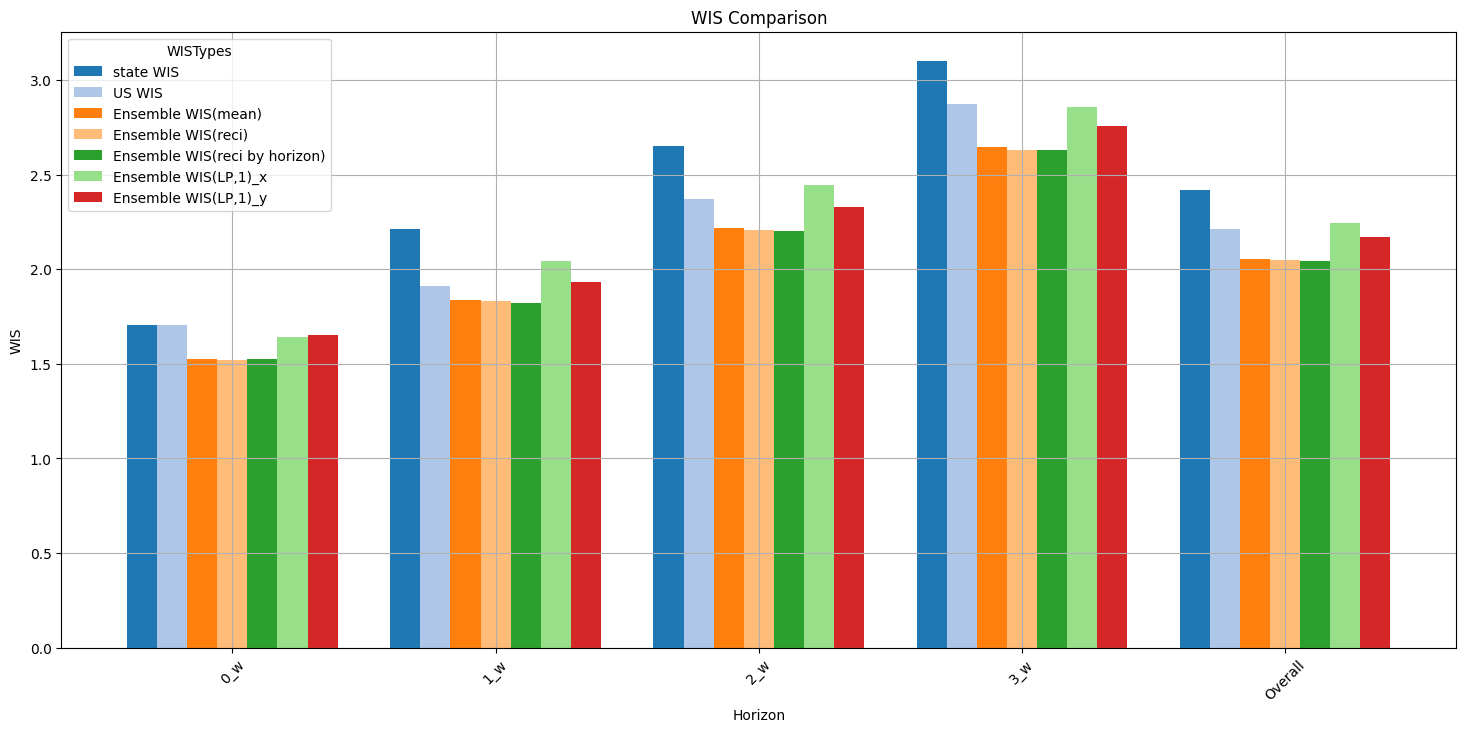

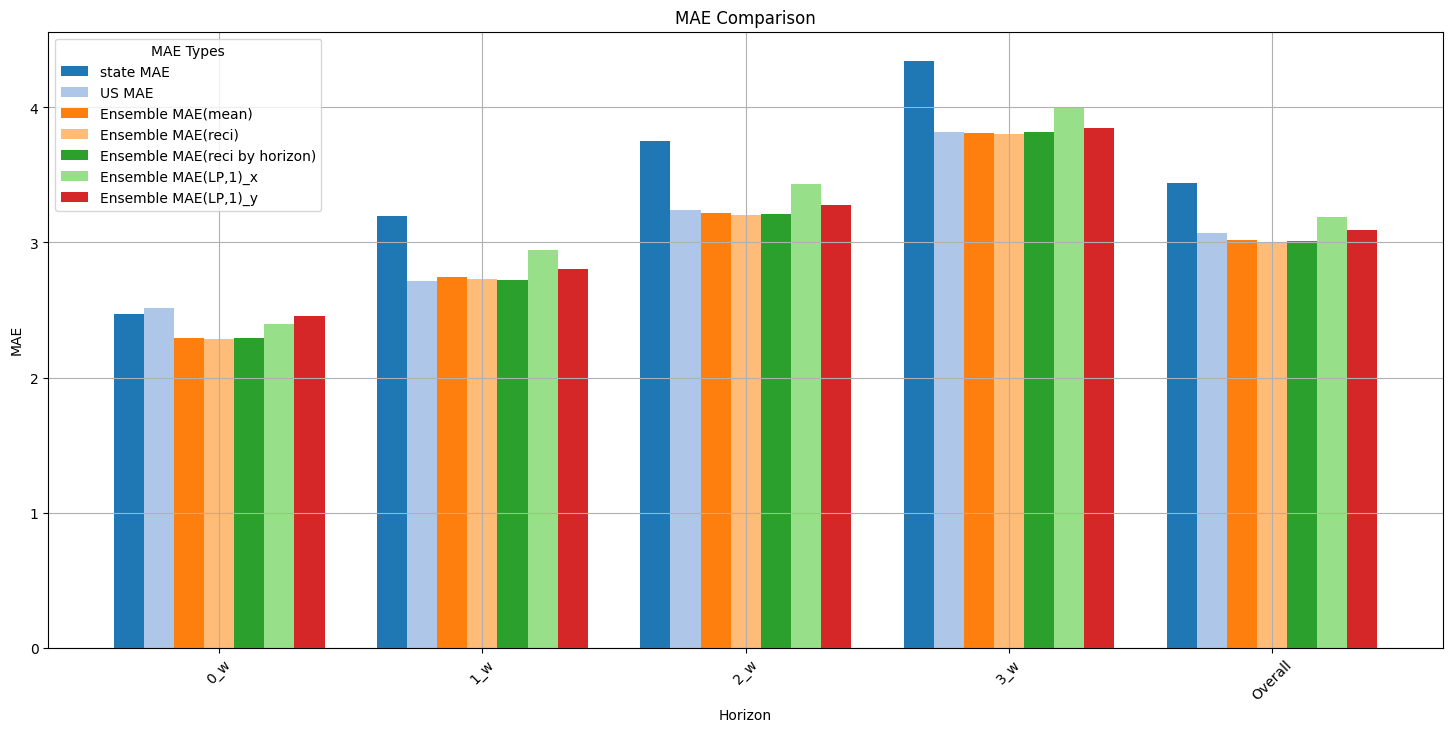

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
colors = sns.color_palette('tab20')
wis_columns = [col for col in mean_df.columns if 'WIS' in col]
mae_columns = [col for col in mean_df.columns if 'MAE' in col]

colors = sns.color_palette('tab20')
ax = mean_df[wis_columns].plot(kind='bar', figsize=(18, 8), title=f'WIS Comparison',width=0.8, color=colors)
ax.set_xlabel('Horizon')
ax.set_ylabel('WIS')
ax.legend(title='WISTypes')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

colors = sns.color_palette('tab20')
ax1 = mean_df[mae_columns].plot(kind='bar', figsize=(18, 8), title=f'MAE Comparison',width=0.8, color=colors)
ax1.set_xlabel('Horizon')
ax1.set_ylabel('MAE')
ax1.legend(title='MAE Types')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#### mae Distribution


In [32]:
state = pd.read_csv('/content/drive/MyDrive/RSV forecasting/Result/result/statemaelargerexp.csv')
us = pd.read_csv('/content/drive/MyDrive/RSV forecasting/Result/result/USmaelarger.csv')
emean = pd.read_csv('/content/drive/MyDrive/RSV forecasting/Result/result/Ensemble_mean_maelargerexp.csv')
ereci = pd.read_csv('/content/drive/MyDrive/RSV forecasting/Result/result/Ensemble_reci_maelargerexp.csv')
ereci_horizon = pd.read_csv('/content/drive/MyDrive/RSV forecasting/Result/result/Ensemble_reci by horizon_maelargerexp.csv')
elp = pd.read_csv('/content/drive/MyDrive/RSV forecasting/Result/result/Ensemble_LP_mae1largerexp.csv')
#elp_avg = pd.read_csv('/content/drive/MyDrive/RSV forecasting/Result/result/Ensemble_LP_avg_mae1larger.csv')
state.rename(columns={'absolute_difference': 'state MAE'}, inplace=True)
us.rename(columns={'absolute_difference': 'US MAE'}, inplace=True)
emean.rename(columns={'absolute_difference': 'Ensemble MAE(mean)'}, inplace=True)
ereci.rename(columns={'absolute_difference': 'Ensemble MAE(reci)'}, inplace=True)
ereci_horizon.rename(columns={'absolute_difference': 'Ensemble MAE(reci by horizon)'}, inplace=True)
elp.rename(columns={'absolute_difference': 'Ensemble MAE(LP,1)'}, inplace=True)
#elp_avg.rename(columns={'absolute_difference': 'Ensemble MAE(LP,1)_avg'}, inplace=True)
merged_df = state.merge(us, on=['reference_date', 'location', 'horizon'])
merged_df = merged_df.merge(emean, on=['reference_date', 'location', 'horizon'])
merged_df = merged_df.merge(ereci, on=['reference_date', 'location', 'horizon'])
merged_df = merged_df.merge(ereci_horizon, on=['reference_date', 'location', 'horizon'])
merged_df = merged_df.merge(elp, on=['reference_date', 'location', 'horizon'])
#merged_df = merged_df.merge(elp_avg, on=['reference_date', 'location', 'horizon'])
overall_means = merged_df.groupby(['reference_date', 'location']).mean().reset_index()
overall_means['horizon'] = 'overall'
final_df = pd.concat([merged_df, overall_means], ignore_index=True)
mae_columns = [col for col in final_df.columns if 'MAE' in col]
final_df.to_csv('/content/drive/MyDrive/RSV forecasting/Result/result/ensemble_fullmae_result_exp.csv', index=False)
final_df

,reference_date,location,horizon,state MAE,US MAE,Ensemble MAE(mean),Ensemble MAE(reci),Ensemble MAE(reci by horizon),"Ensemble MAE(LP,1)"
0,2023-10-14,13,0,0.939812,0.422646,0.258583,0.258583,0.258583,0.258583
1,2023-10-14,13,1,0.939812,0.299466,0.320173,0.320173,0.320173,0.320173
2,2023-10-14,13,2,1.534640,0.096862,0.815751,0.815751,0.815751,0.815751
3,2023-10-14,13,3,1.517112,0.471917,0.994515,0.994515,0.994515,0.994515
4,2023-10-14,24,0,0.057068,0.713859,0.385463,0.385463,0.385463,0.385463
...,...,...,...,...,...,...,...,...,...
1195,2024-02-24,35,overall,1.190919,0.329280,0.738703,0.786081,0.765897,1.190919
1196,2024-02-24,36,overall,0.678383,0.107749,0.363826,0.396781,0.376530,0.678383
1197,2024-02-24,41,overall,0.266019,0.581458,0.423739,0.407215,0.414345,0.266019
1198,2024-02-24,47,overall,0.198813,0.095796,0.051509,0.066941,0.058376,0.198813


In [ ]:
median_df = final_df.drop(columns=['reference_date', 'location'])
md = median_df.groupby('horizon').median()
colors = sns.color_palette('tab20')
ax = md.plot(kind='bar', figsize=(18, 8), title=f'Median MAE Comparison',width=0.8, color=colors)
ax.set_xlabel('Horizon')
ax.set_ylabel('MAE')
ax.legend(title='MAETypes')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

NameError: name 'sns' is not defined

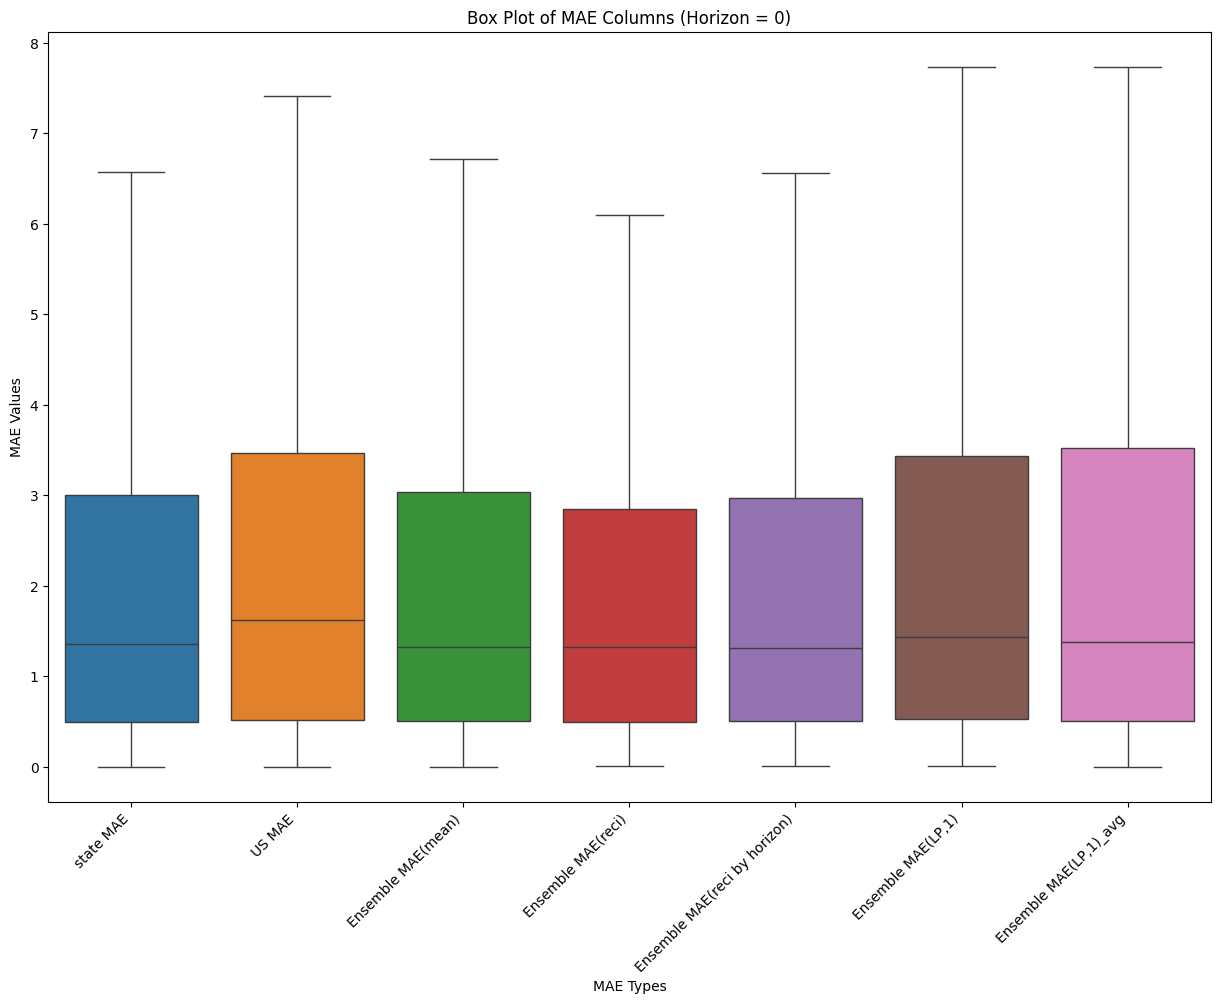

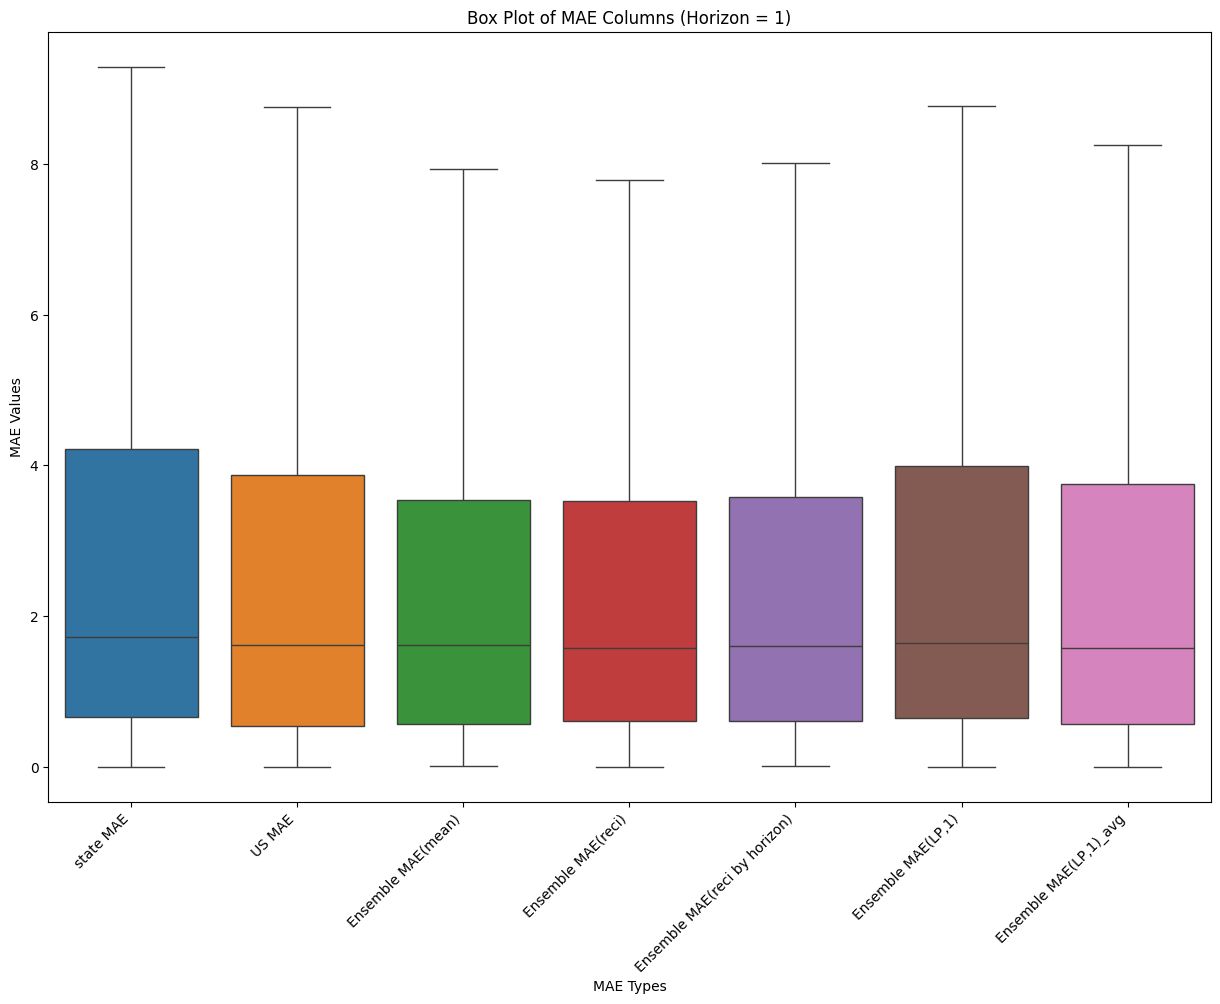

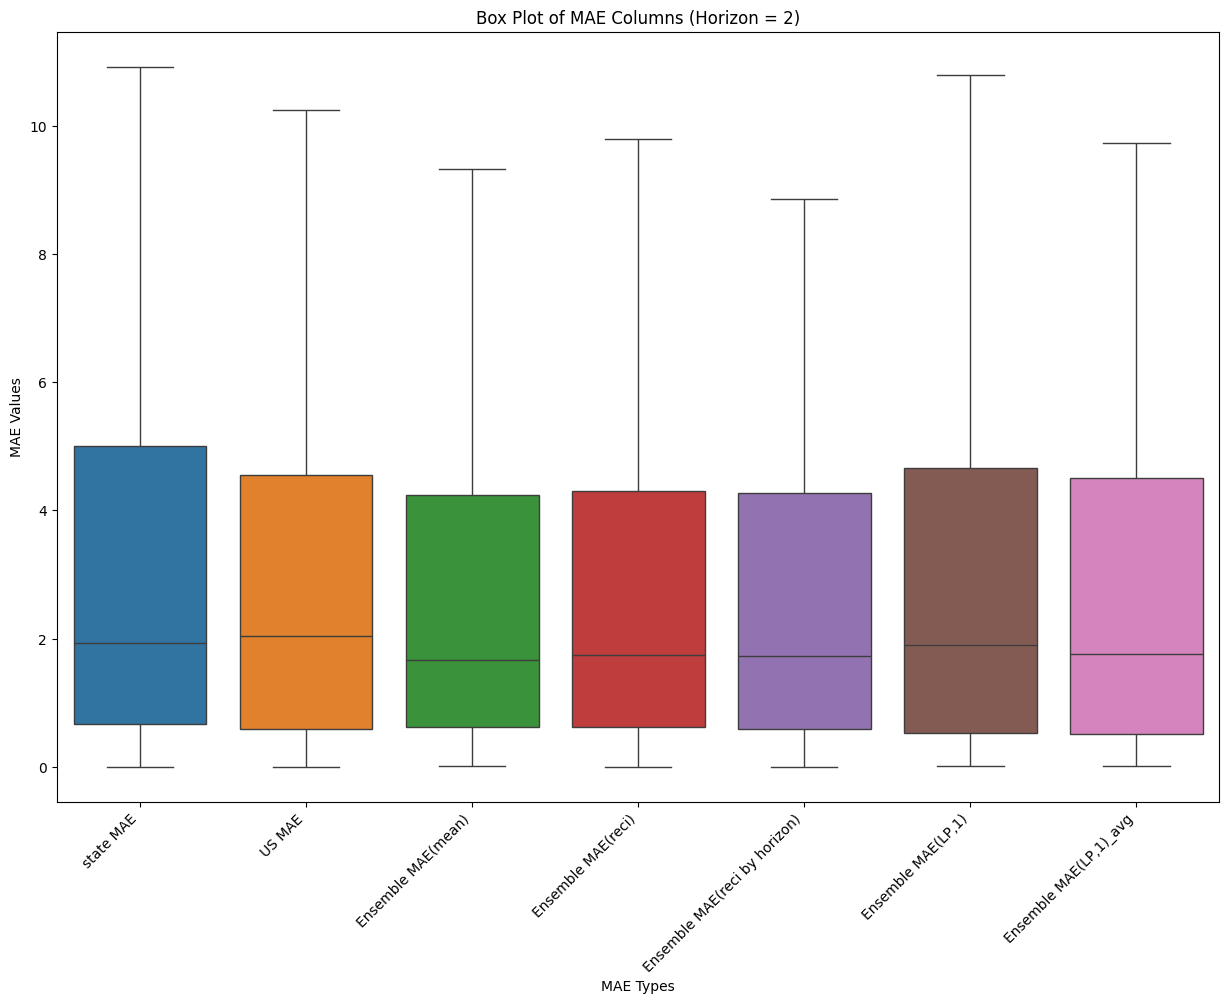

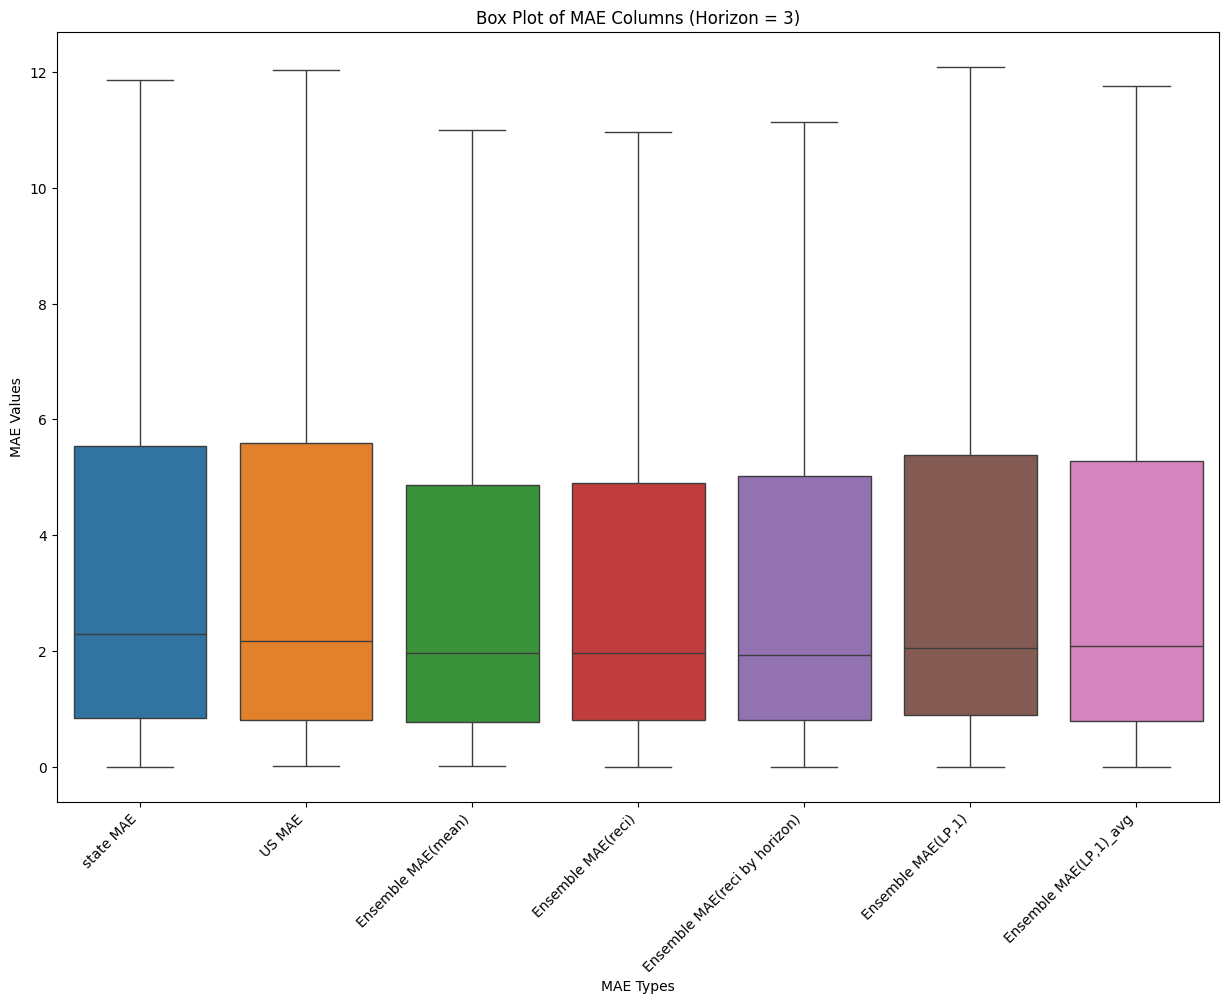

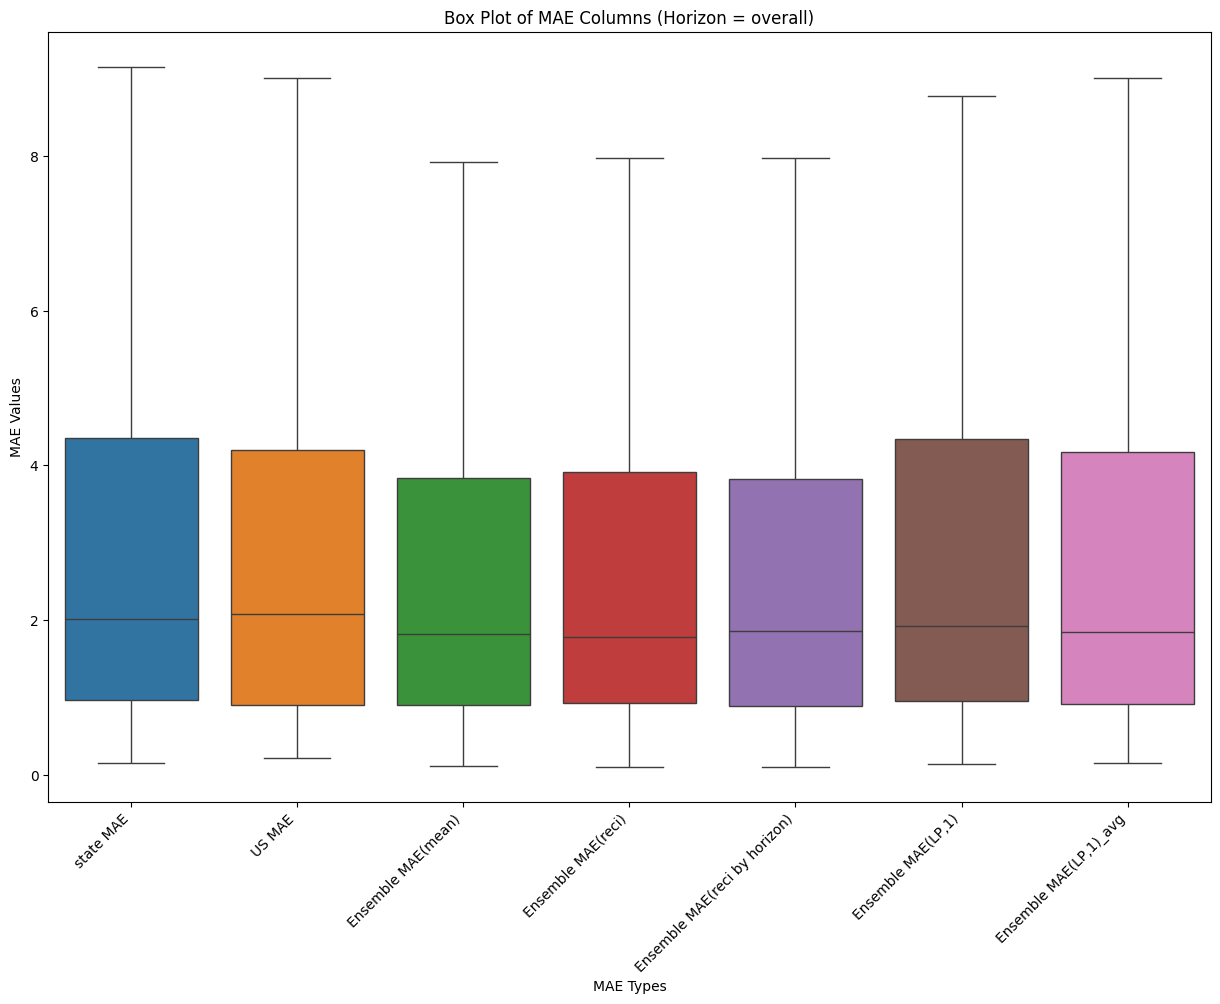

In [ ]:
unique_horizons = final_df['horizon'].unique()

# Plot box plots for each horizon
for horizon in unique_horizons:
    horizon_df = final_df[final_df['horizon'] == horizon]

    plt.figure(figsize=(15, 10))
    sns.boxplot(data=horizon_df[mae_columns], showfliers=False)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Box Plot of MAE Columns (Horizon = {horizon})')
    plt.ylabel('MAE Values')
    plt.xlabel('MAE Types')
    plt.show()

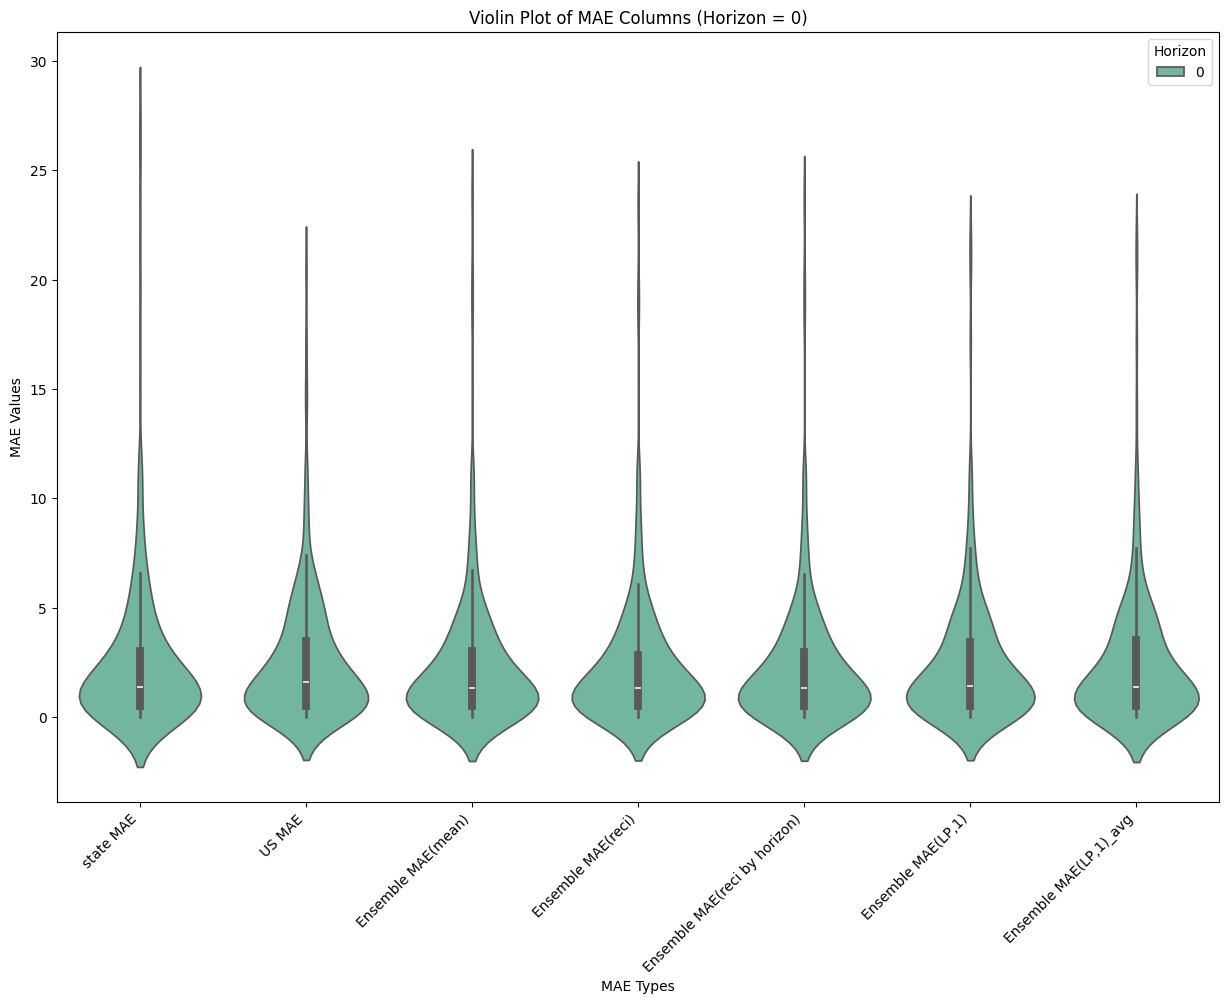

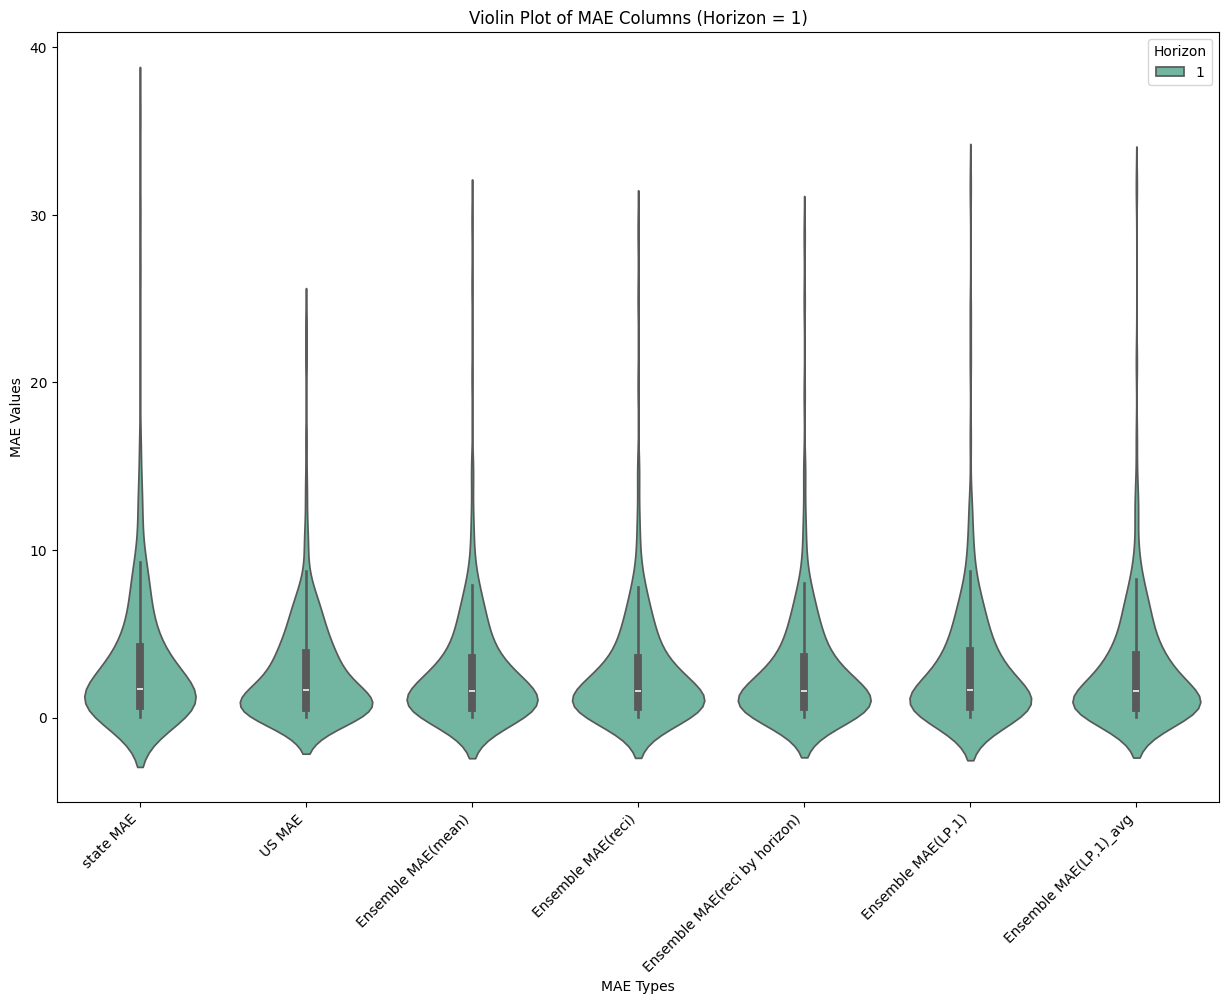

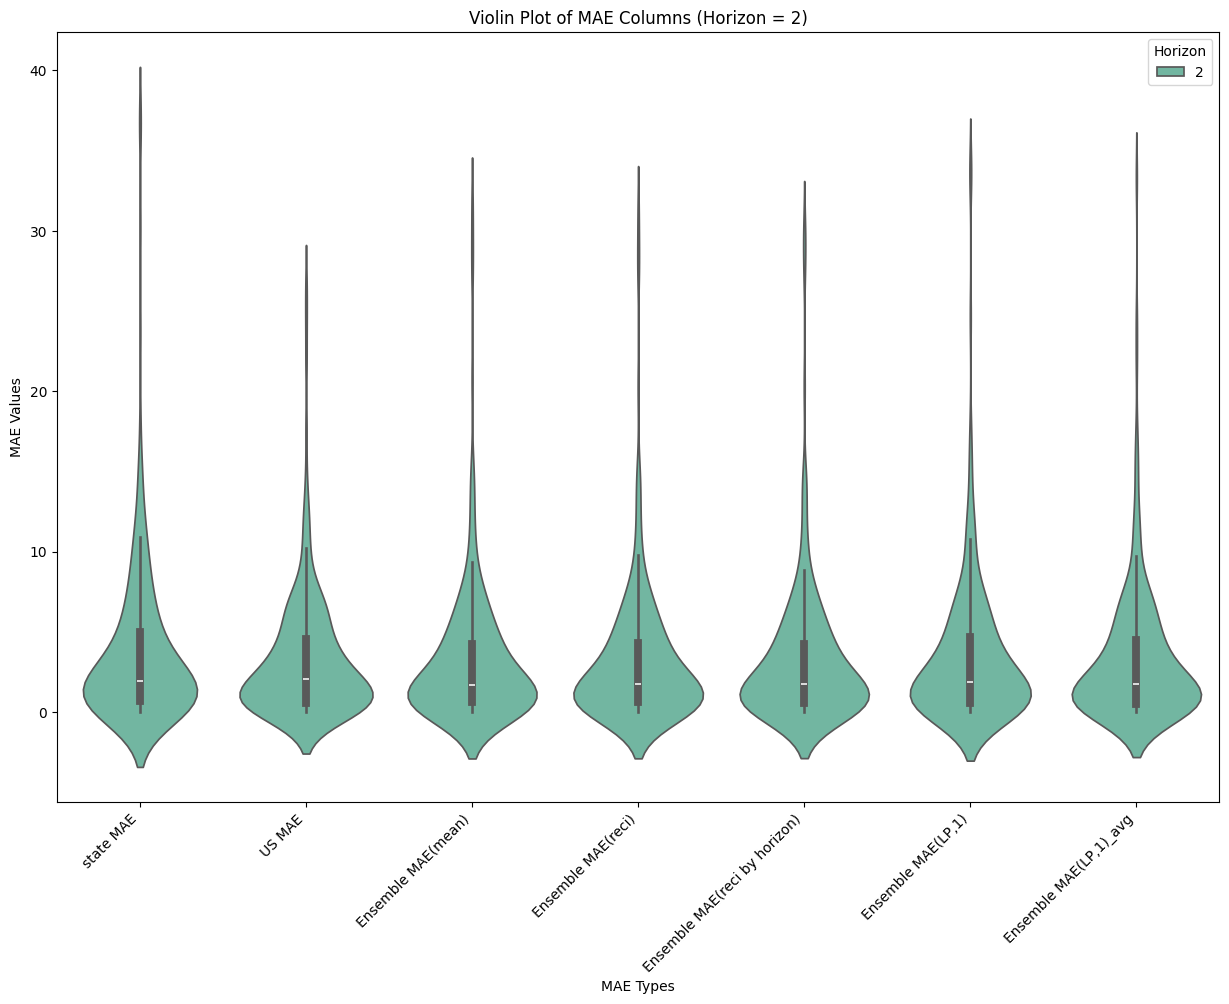

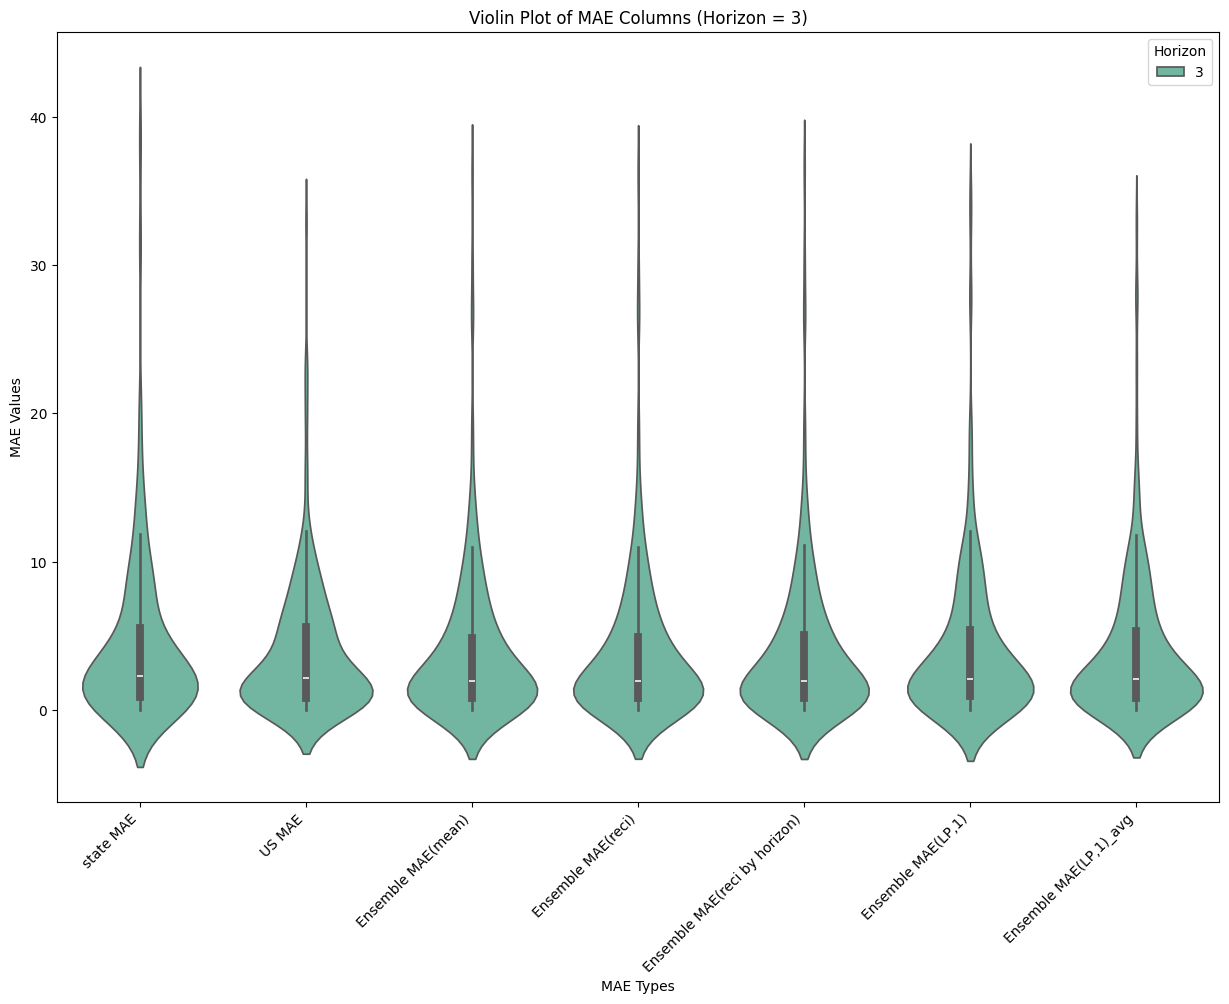

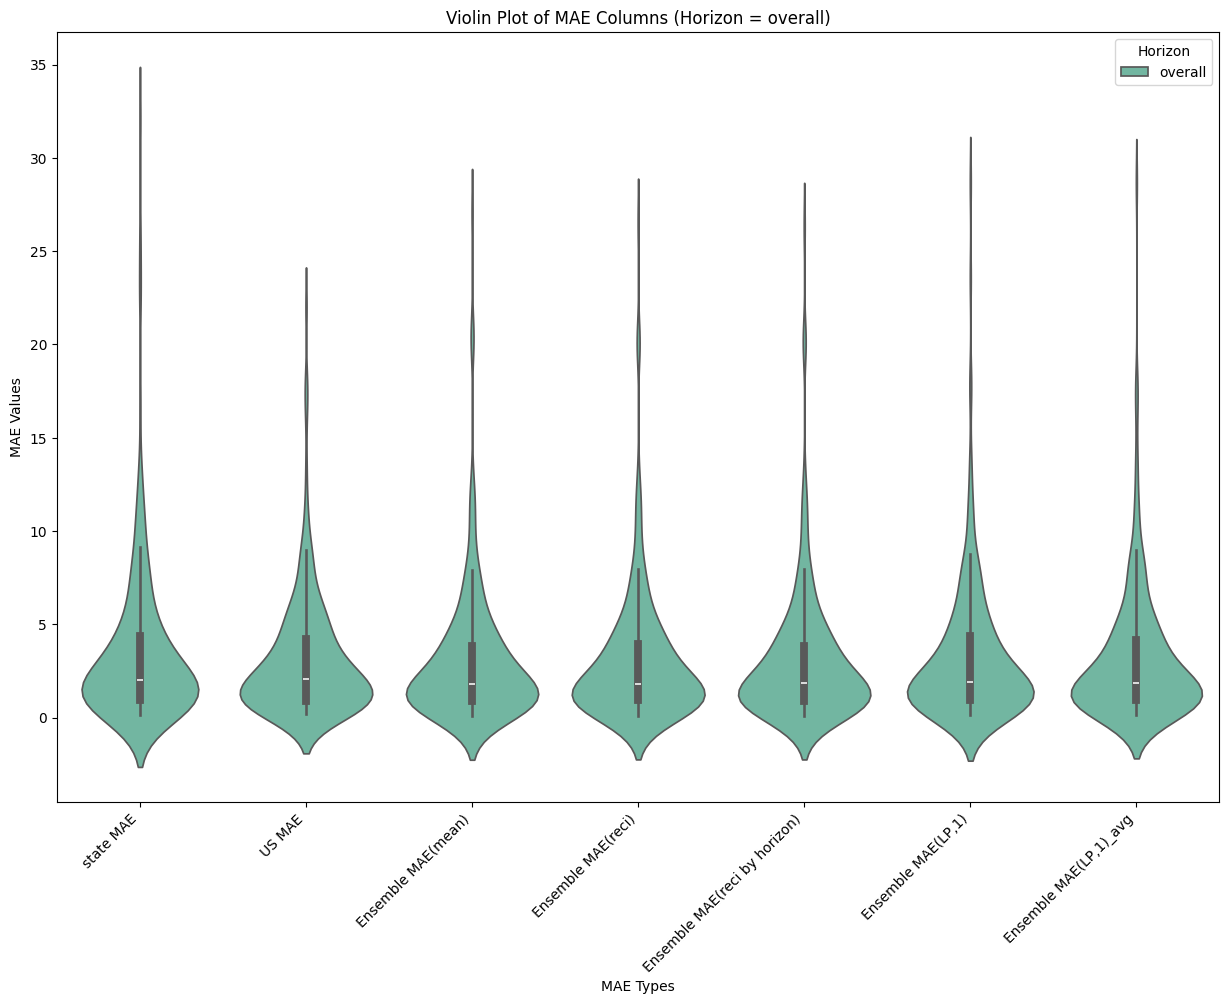

In [ ]:
for horizon in unique_horizons:
    horizon_df = final_df[final_df['horizon'] == horizon]

    # Melt the dataframe for easier plotting
    melted_df = horizon_df.melt(id_vars=['reference_date', 'location', 'horizon'], value_vars=mae_columns,
                                var_name='MAE_Type', value_name='MAE_Value')

    plt.figure(figsize=(15, 10))
    sns.violinplot(x='MAE_Type', y='MAE_Value', data=melted_df, hue='horizon', palette='Set2')
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Violin Plot of MAE Columns (Horizon = {horizon})')
    plt.ylabel('MAE Values')
    plt.xlabel('MAE Types')
    plt.legend(title='Horizon', loc='upper right')
    plt.show()

#### wis Distribution


In [33]:
import pandas as pd

# Load the CSV files
state = pd.read_csv('/content/drive/MyDrive/RSV forecasting/Result/result/statewislargerexp.csv')
us = pd.read_csv('/content/drive/MyDrive/RSV forecasting/Result/result/USwislarger.csv')
emean = pd.read_csv('/content/drive/MyDrive/RSV forecasting/Result/result/Ensemble_mean_wislargerexp.csv')
ereci = pd.read_csv('/content/drive/MyDrive/RSV forecasting/Result/result/Ensemble_reci_wislargerexp.csv')
ereci_horizon = pd.read_csv('/content/drive/MyDrive/RSV forecasting/Result/result/Ensemble_reci by horizon_wislargerexp.csv')
elp = pd.read_csv('/content/drive/MyDrive/RSV forecasting/Result/result/Ensemble_LP_wis1largerexp.csv')
#elp_avg = pd.read_csv('/content/drive/MyDrive/RSV forecasting/Result/result/Ensemble_LP_avg_wis1larger.csv')

# Rename the 'absolute_difference' column to 'state WIS' and so on
state.rename(columns={'WIS': 'state WIS'}, inplace=True)
us.rename(columns={'WIS': 'US WIS'}, inplace=True)
emean.rename(columns={'WIS': 'Ensemble WIS(mean)'}, inplace=True)
ereci.rename(columns={'WIS': 'Ensemble WIS(reci)'}, inplace=True)
ereci_horizon.rename(columns={'WIS': 'Ensemble WIS(reci by horizon)'}, inplace=True)
elp.rename(columns={'WIS': 'Ensemble WIS(LP,1)'}, inplace=True)
#elp_avg.rename(columns={'WIS': 'Ensemble WIS(LP,1)_avg'}, inplace=True)

# Merge dataframes on reference_date, location, and horizon
merged_df = state.merge(us, on=['date', 'location', 'horizon'])
merged_df = merged_df.merge(emean, on=['date', 'location', 'horizon'])
merged_df = merged_df.merge(ereci, on=['date', 'location', 'horizon'])
merged_df = merged_df.merge(ereci_horizon, on=['date', 'location', 'horizon'])
merged_df = merged_df.merge(elp, on=['date', 'location', 'horizon'])
#merged_df = merged_df.merge(elp_avg, on=['date', 'location', 'horizon'])

# Calculate overall means for each reference_date and location combination
overall_means = merged_df.groupby(['date', 'location']).mean().reset_index()
overall_means['horizon'] = 'overall'

# Concatenate the overall means with the merged dataframe
final_df = pd.concat([merged_df, overall_means], ignore_index=True)

# Save the final dataframe to a new CSV file
final_df.to_csv('/content/drive/MyDrive/RSV forecasting/Result/result/ensemble_fullwis_result_exp.csv', index=False)

# Display the final dataframe
final_df


,location,date,horizon,state WIS,US WIS,Ensemble WIS(mean),Ensemble WIS(reci),Ensemble WIS(reci by horizon),"Ensemble WIS(LP,1)"
0,6,2023-10-14,0,0.308990,0.083357,0.104181,0.104181,0.104181,0.104181
1,6,2023-10-14,1,0.200941,0.092880,0.112390,0.112390,0.112390,0.112390
2,6,2023-10-14,2,0.172636,0.181521,0.174777,0.174777,0.174777,0.174777
3,6,2023-10-14,3,0.271481,0.231900,0.250457,0.250457,0.250457,0.250457
4,8,2023-10-14,0,0.129177,0.115960,0.121042,0.121042,0.121042,0.121042
...,...,...,...,...,...,...,...,...,...
1195,35,2024-02-24,overall,0.689590,0.210567,0.430288,0.456681,0.444535,0.689590
1196,36,2024-02-24,overall,0.394912,0.093588,0.227797,0.244664,0.233710,0.394912
1197,41,2024-02-24,overall,0.174316,0.422788,0.249683,0.236155,0.242590,0.174316
1198,47,2024-02-24,overall,0.151291,0.062110,0.087185,0.092969,0.089579,0.151291


In [25]:
final_df['location'].unique()

array([13, 24, 26, 27, 35, 36, 41, 47, 49])

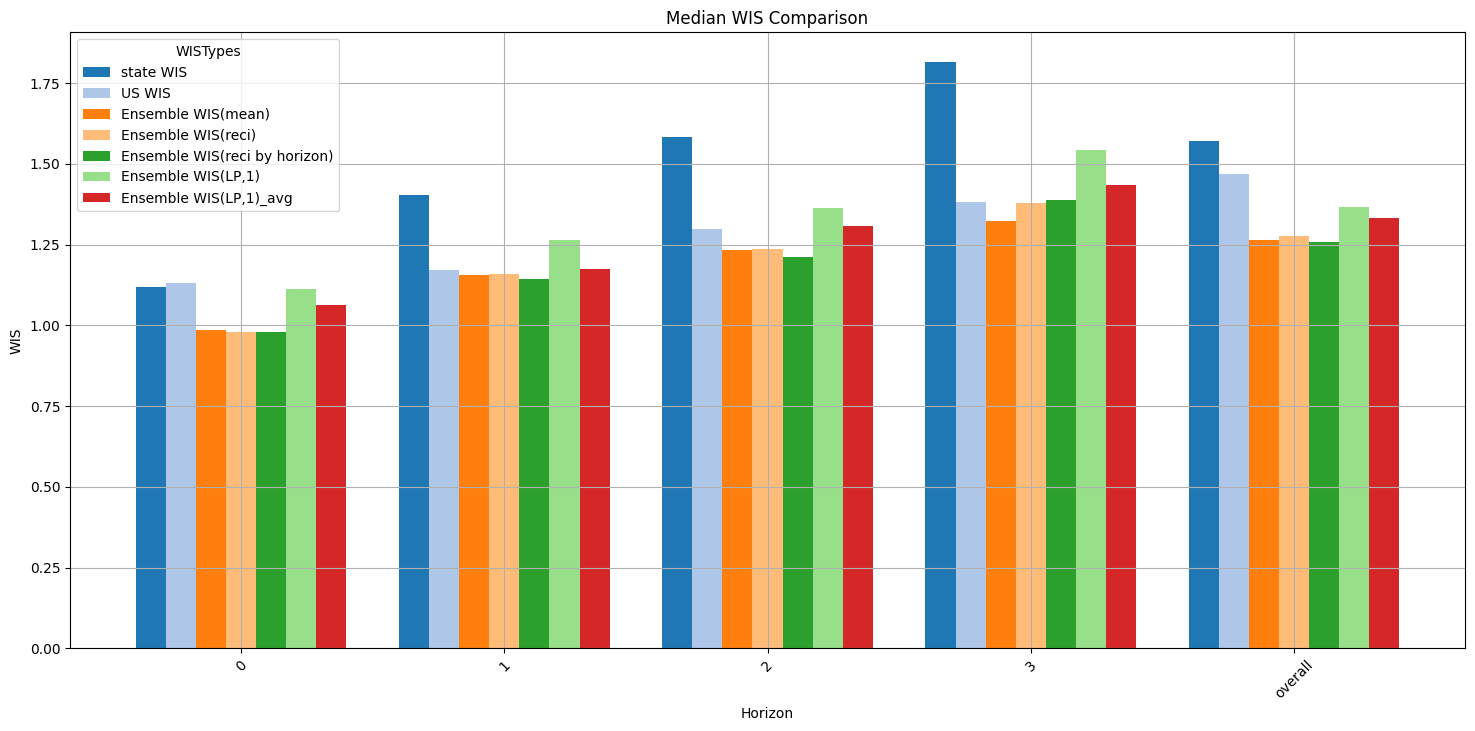

In [ ]:
median_df = final_df.drop(columns=['date', 'location'])
md = median_df.groupby('horizon').median()
colors = sns.color_palette('tab20')
ax = md.plot(kind='bar', figsize=(18, 8), title=f'Median WIS Comparison',width=0.8, color=colors)
ax.set_xlabel('Horizon')
ax.set_ylabel('WIS')
ax.legend(title='WISTypes')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

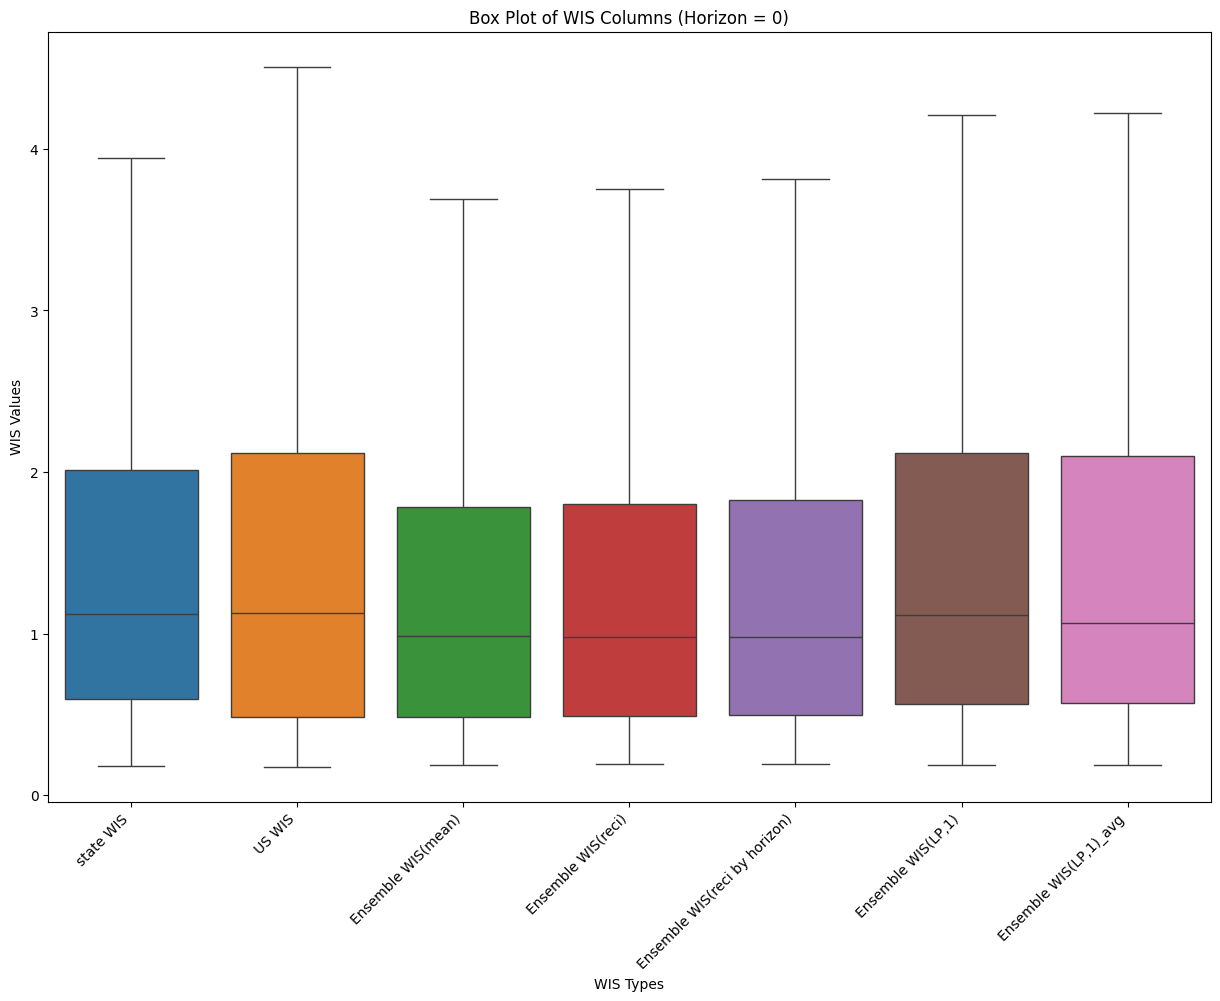

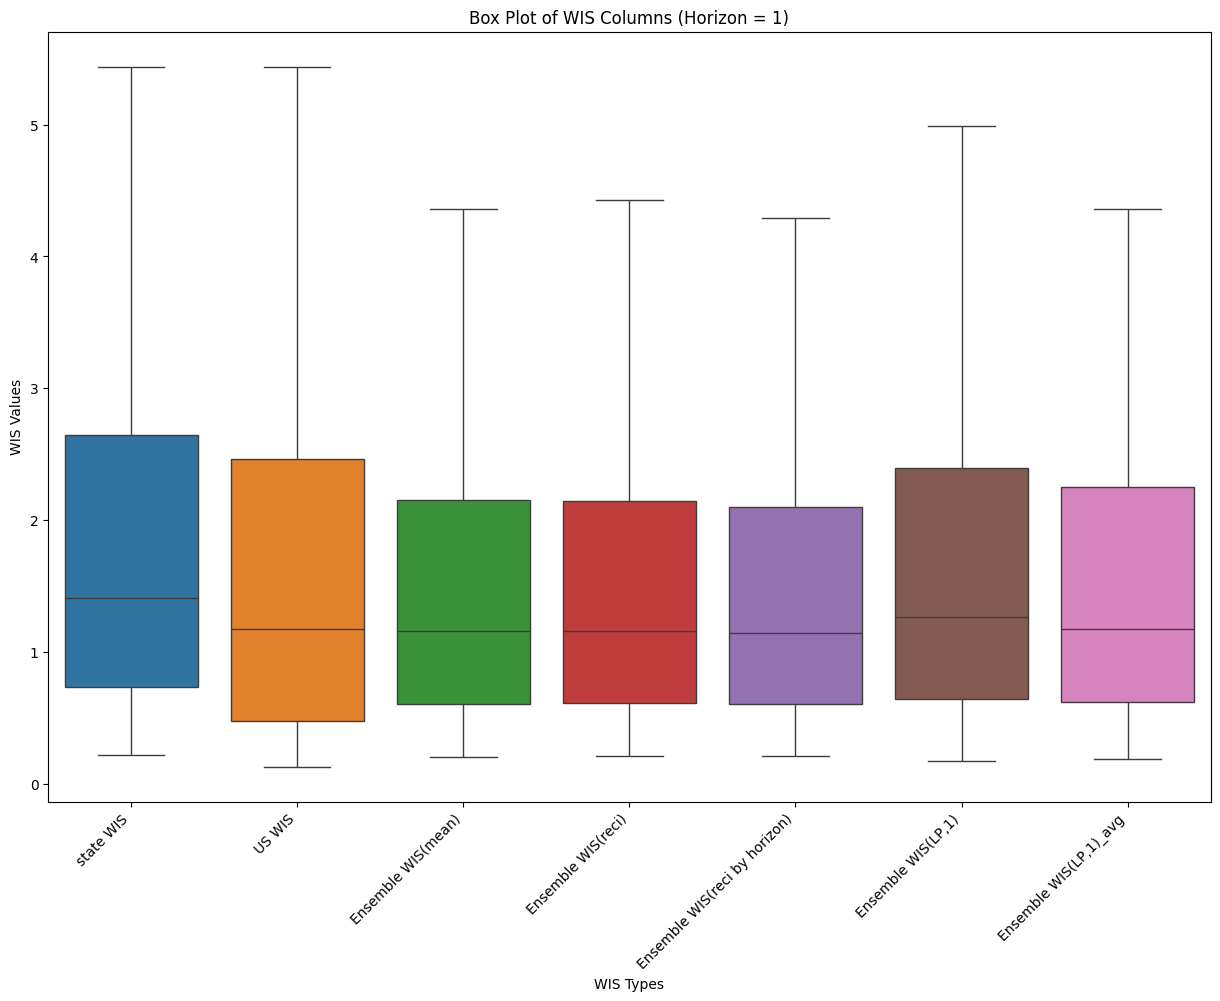

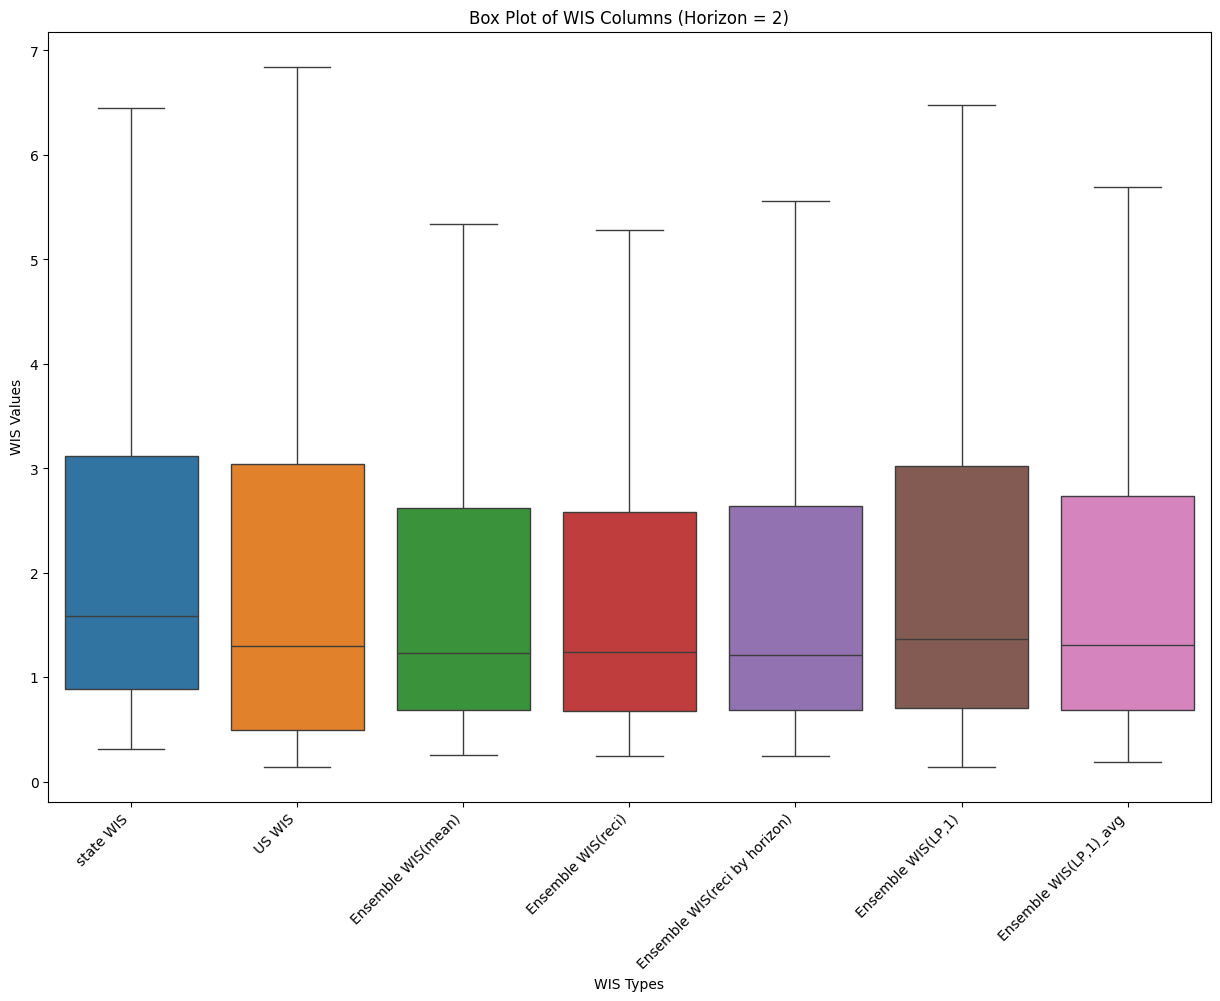

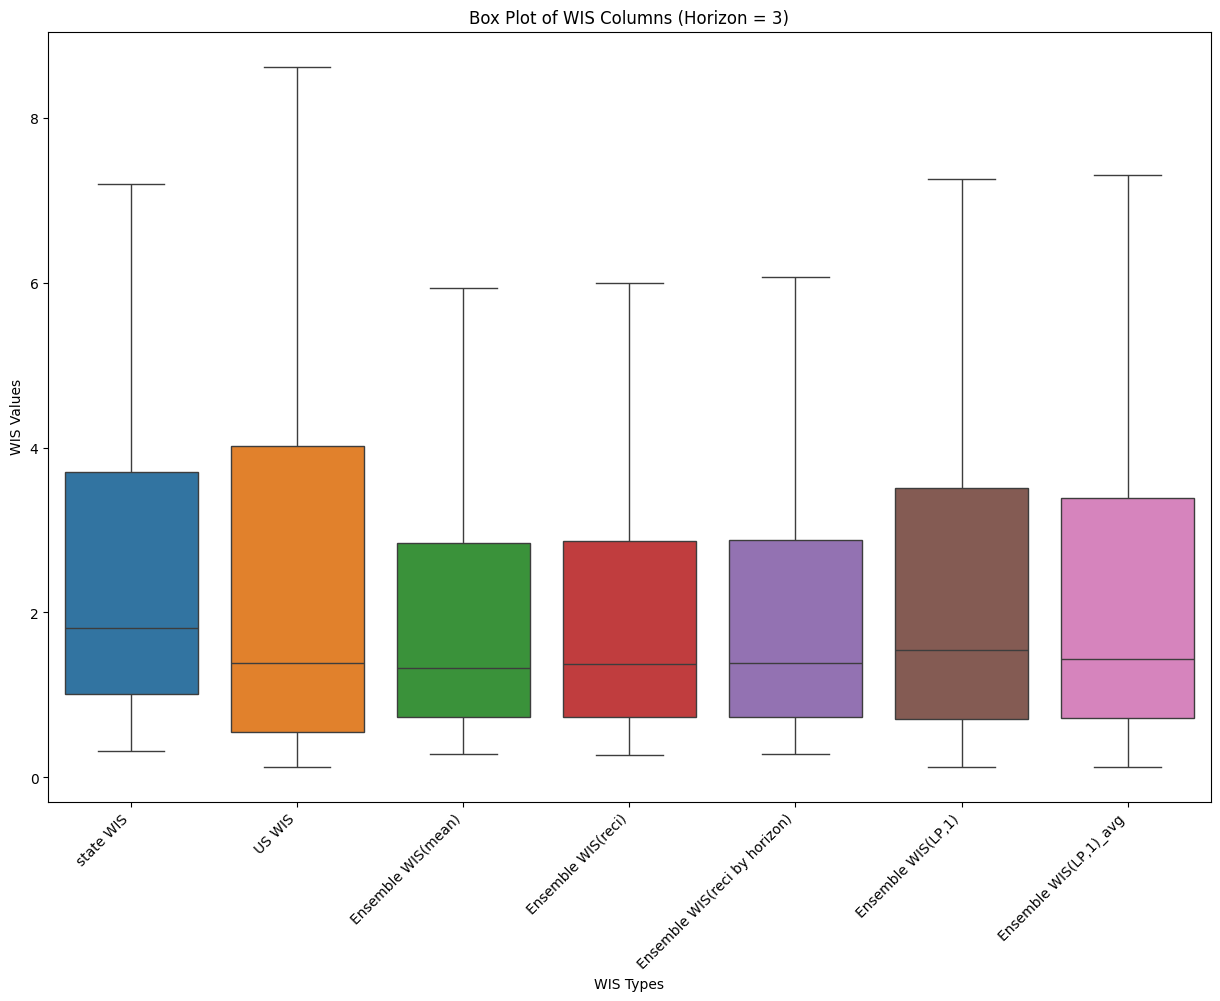

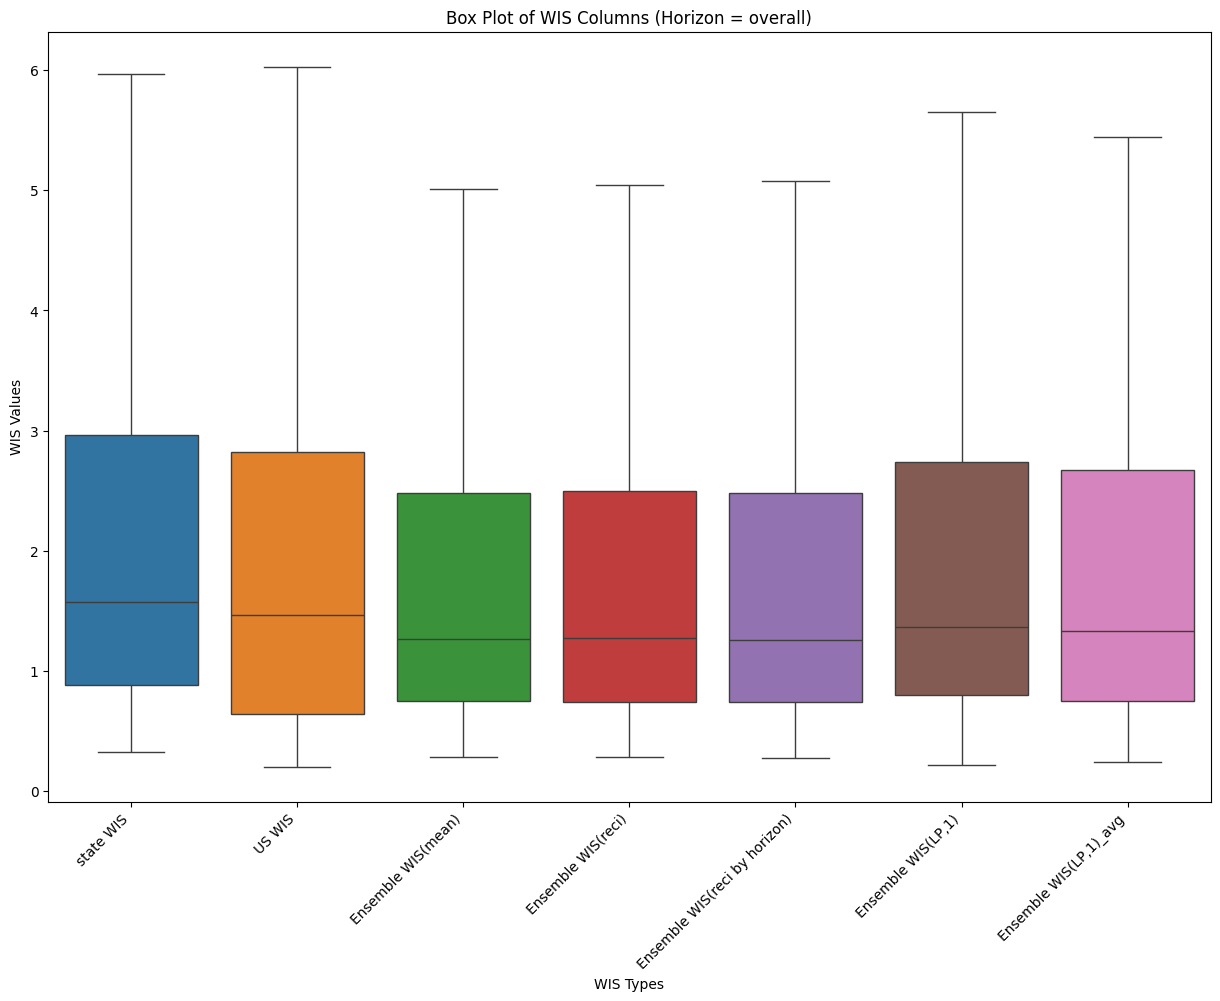

In [ ]:
unique_horizons = final_df['horizon'].unique()
wis_columns = [col for col in final_df.columns if 'WIS' in col]
# Plot box plots for each horizon
for horizon in unique_horizons:
    horizon_df = final_df[final_df['horizon'] == horizon]

    plt.figure(figsize=(15, 10))
    sns.boxplot(data=horizon_df[wis_columns], showfliers=False)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Box Plot of WIS Columns (Horizon = {horizon})')
    plt.ylabel('WIS Values')
    plt.xlabel('WIS Types')
    plt.show()